# Importações

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Pré-processamento
  ### Depois do pré-processamento utilizar o dataframe *ts_rs_residencial* para acessar a série temporal.
  ### timestamps_treino
  ### timestamps_teste
  ### consumo_treino
  ### consumo_teste

In [33]:
!wget https://www.inf.ufrgs.br/~mpizzutti/CMP618/consumo.csv
df = pd.read_csv('consumo.csv')
df.head()

--2024-02-03 08:55:33--  https://www.inf.ufrgs.br/~mpizzutti/CMP618/consumo.csv
Resolving www.inf.ufrgs.br (www.inf.ufrgs.br)... 143.54.11.34
Connecting to www.inf.ufrgs.br (www.inf.ufrgs.br)|143.54.11.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1098358 (1.0M) [application/octet-stream]
Saving to: ‘consumo.csv.1’

consumo.csv.1       100%[===================>]   1.05M  6.46MB/s    in 0.2s    

2024-02-03 08:55:34 (6.46 MB/s) - ‘consumo.csv.1’ saved [1098358/1098358]



,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
0,2004,1,RO,Total,NaN,112812.00
1,2004,1,AC,Total,NaN,34840.05
2,2004,1,AM,Total,NaN,274773.00
3,2004,1,RR,Total,NaN,31695.63
4,2004,1,PA,Total,NaN,1011353.04


In [34]:
df['data'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str), format='%Y-%m')
df_rs_residencial = df[(df['sigla_uf'] == 'RS') & (df['tipo_consumo'] == 'Residencial')]
df_rs_residencial.tail()

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo,data
17383,2021,8,RS,Residencial,NaN,756429.24,2021-08-01
17410,2021,9,RS,Residencial,NaN,652923.60,2021-09-01
17437,2021,10,RS,Residencial,NaN,688945.37,2021-10-01
17464,2021,11,RS,Residencial,NaN,743034.01,2021-11-01
17491,2021,12,RS,Residencial,NaN,785861.25,2021-12-01


In [35]:
ts_rs_residencial = df_rs_residencial.drop(['ano','mes','tipo_consumo','numero_consumidores', 'sigla_uf'], axis=1)
ts_rs_residencial = ts_rs_residencial.set_index('data')
ts_rs_residencial.head()

,consumo
data,
2004-01-01,456670.2
2004-02-01,455907.3
2004-03-01,453566.8
2004-04-01,470612.3
2004-05-01,446184.4


In [36]:
# Dividindo os dados em treino e teste
timestamps_treino = ts_rs_residencial[ts_rs_residencial.index<'2018-01-01'].index.values
timestamps_teste = ts_rs_residencial[ts_rs_residencial.index>='2018-01-01'].index.values
consumo_treino = ts_rs_residencial[ts_rs_residencial.index<'2018-01-01'].values
consumo_teste = ts_rs_residencial[ts_rs_residencial.index>='2018-01-01'].values

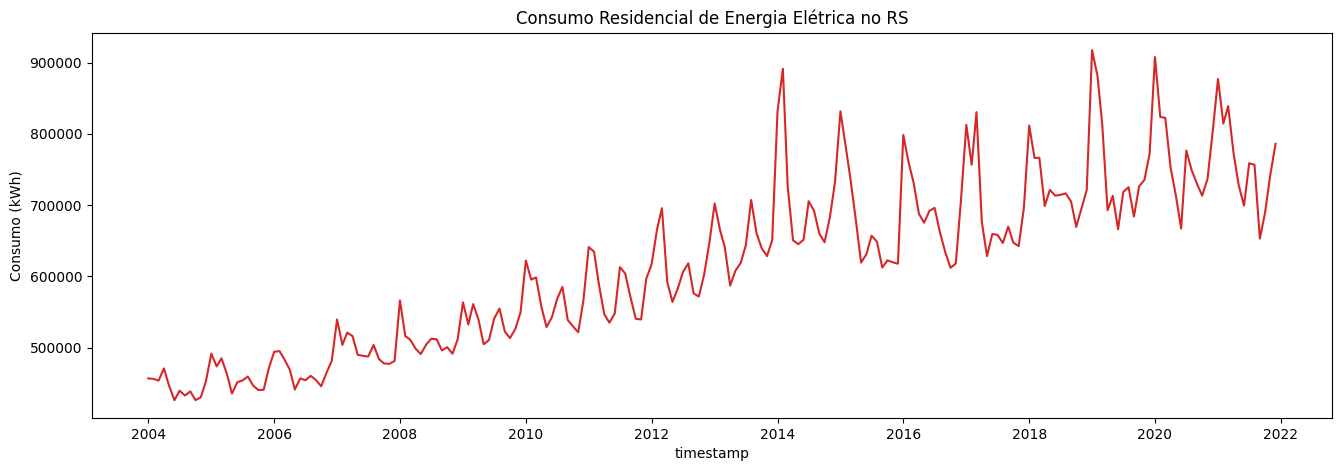

In [37]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(ts_rs_residencial.index, ts_rs_residencial['consumo'], color='tab:red')
plt.gca().set(title='Consumo Residencial de Energia Elétrica no RS', xlabel='timestamp', ylabel='Consumo (kWh)')
plt.show()

# Busca Bayesiana

In [42]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

# Define the objective function
def objective(params):
    order = (int(params['p']), int(params['d']), int(params['q']))
    seasonal_order = (int(params['P']), int(params['D']), int(params['Q']), 12)

    model = SARIMAX(consumo_treino, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    predictions = model_fit.predict(start=len(consumo_treino), end=len(consumo_treino)+len(consumo_teste)-1)
    mse = mean_squared_error(consumo_teste, predictions)

    return {'loss': mse, 'status': STATUS_OK}

# Define the hyperparameters space
space = {
    'p': hp.quniform('p', 0, 5, 1),
    'd': hp.quniform('d', 0, 2, 1),
    'q': hp.quniform('q', 0, 5, 1),
    'P': hp.quniform('P', 0, 5, 1),
    'D': hp.quniform('D', 0, 2, 1),
    'Q': hp.quniform('Q', 0, 5, 1)
}

# Run the algorithm
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

print('Best parameters:', best)

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20254D+01    |proj g|=  3.02291D-01


 This problem is unconstrained.



At iterate    5    f=  1.18734D+01    |proj g|=  3.34582D-02

At iterate   10    f=  1.18419D+01    |proj g|=  5.65314D-02

At iterate   15    f=  1.18380D+01    |proj g|=  5.79634D-03

At iterate   20    f=  1.18363D+01    |proj g|=  8.79993D-03

At iterate   25    f=  1.18319D+01    |proj g|=  2.63442D-02

At iterate   30    f=  1.18307D+01    |proj g|=  9.70996D-03

At iterate   35    f=  1.18305D+01    |proj g|=  5.84584D-03

At iterate   40    f=  1.18301D+01    |proj g|=  1.46964D-02

At iterate   45    f=  1.18300D+01    |proj g|=  1.11659D-02

At iterate   50    f=  1.18300D+01    |proj g|=  4.45764D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  0%|          | 1/200 [00:15<51:12, 15.44s/trial, best loss: 4084460066.870213]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22657D+01    |proj g|=  6.02716D-01


/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.



At iterate    5    f=  1.19049D+01    |proj g|=  1.18138D-01

At iterate   10    f=  1.18619D+01    |proj g|=  4.45353D-02

At iterate   15    f=  1.18457D+01    |proj g|=  1.77773D-02

At iterate   20    f=  1.18420D+01    |proj g|=  3.54607D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     27      1     0     0   1.488D-04   1.184D+01
  F =   11.841905495231314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
  1%|          | 2/200 [00:21<32:15,  9.77s/trial, best loss: 4084460066.870213]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05710D+01    |proj g|=  6.48480D-01


 This problem is unconstrained.



At iterate    5    f=  1.03982D+01    |proj g|=  6.42126D-02

At iterate   10    f=  1.03871D+01    |proj g|=  2.76333D-02

At iterate   15    f=  1.03403D+01    |proj g|=  4.69607D-02

At iterate   20    f=  1.03352D+01    |proj g|=  3.04420D-02

At iterate   25    f=  1.03310D+01    |proj g|=  1.52958D-02

At iterate   30    f=  1.03288D+01    |proj g|=  8.78088D-03

At iterate   35    f=  1.03283D+01    |proj g|=  2.68258D-03

At iterate   40    f=  1.03274D+01    |proj g|=  9.57756D-03

At iterate   45    f=  1.03269D+01    |proj g|=  4.82090D-04

At iterate   50    f=  1.03268D+01    |proj g|=  2.16686D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  2%|▏         | 3/200 [00:43<51:03, 15.55s/trial, best loss: 3272928191.3008614]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19340D+01    |proj g|=  3.48505D-01


 This problem is unconstrained.



At iterate    5    f=  1.17811D+01    |proj g|=  1.16663D-02

At iterate   10    f=  1.17804D+01    |proj g|=  1.16018D-02

At iterate   15    f=  1.17801D+01    |proj g|=  1.23963D-02

At iterate   20    f=  1.17760D+01    |proj g|=  1.08778D-02

At iterate   25    f=  1.17735D+01    |proj g|=  1.39849D-02

At iterate   30    f=  1.17717D+01    |proj g|=  1.20292D-03

At iterate   35    f=  1.17717D+01    |proj g|=  1.63952D-03

At iterate   40    f=  1.17716D+01    |proj g|=  2.03682D-03

At iterate   45    f=  1.17712D+01    |proj g|=  7.37350D-03

At iterate   50    f=  1.17710D+01    |proj g|=  2.65617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35084D+02    |proj g|=  4.57340D+02


 This problem is unconstrained.



At iterate    5    f=  1.18624D+01    |proj g|=  1.11417D-01

At iterate   10    f=  1.18043D+01    |proj g|=  1.65923D-02

At iterate   15    f=  1.18002D+01    |proj g|=  1.03078D-02

At iterate   20    f=  1.17946D+01    |proj g|=  4.22420D-02

At iterate   25    f=  1.17795D+01    |proj g|=  1.57629D-02

At iterate   30    f=  1.17774D+01    |proj g|=  3.40599D-03

At iterate   35    f=  1.17770D+01    |proj g|=  1.21330D-03

At iterate   40    f=  1.17770D+01    |proj g|=  1.20786D-03

At iterate   45    f=  1.17770D+01    |proj g|=  8.53520D-05

At iterate   50    f=  1.17770D+01    |proj g|=  5.96918D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  2%|▎         | 5/200 [00:53<29:59,  9.23s/trial, best loss: 1926691259.9043953]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16676D+01    |proj g|=  2.81050D+00


/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

 This problem is unconstrained.



At iterate    5    f=  1.03408D+01    |proj g|=  2.09036D-02

At iterate   10    f=  1.03299D+01    |proj g|=  9.34600D-03

At iterate   15    f=  1.03198D+01    |proj g|=  1.85833D-02

At iterate   20    f=  1.03180D+01    |proj g|=  5.52354D-04

At iterate   25    f=  1.03180D+01    |proj g|=  9.57900D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     30      1     0     0   9.396D-06   1.032D+01
  F =   10.318010601405499     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
  3%|▎         | 6/200 [00:58<24:30,  7.58s/trial, best loss: 1926691259.9043953]RUNNING THE L-BFGS-B CODE

     

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

 This problem is unconstrained.



At iterate   10    f=  1.09948D+01    |proj g|=  3.94537D-02

At iterate   15    f=  1.09941D+01    |proj g|=  8.29592D-03

At iterate   20    f=  1.09850D+01    |proj g|=  6.88844D-02

At iterate   25    f=  1.09750D+01    |proj g|=  6.22528D-02

At iterate   30    f=  1.09676D+01    |proj g|=  2.71619D-02

At iterate   35    f=  1.09566D+01    |proj g|=  7.58076D-02

At iterate   40    f=  1.09529D+01    |proj g|=  3.06212D-02

At iterate   45    f=  1.09507D+01    |proj g|=  6.38813D-02

At iterate   50    f=  1.09466D+01    |proj g|=  5.24175D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     73   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12798D+01    |proj g|=  8.51861D-01


 This problem is unconstrained.



At iterate    5    f=  1.08594D+01    |proj g|=  7.45470D-02

At iterate   10    f=  1.08366D+01    |proj g|=  1.31612D-02

At iterate   15    f=  1.08353D+01    |proj g|=  3.09744D-04

At iterate   20    f=  1.08353D+01    |proj g|=  3.06971D-04

At iterate   25    f=  1.08351D+01    |proj g|=  1.24655D-02

At iterate   30    f=  1.08345D+01    |proj g|=  2.39450D-03

At iterate   35    f=  1.08345D+01    |proj g|=  2.79684D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     46      1     0     0   1.229D-04   1.083D+01
  F =   10.834500218648502     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.17638D+01    |proj g|=  9.94080D-02

At iterate   10    f=  1.17565D+01    |proj g|=  1.50538D-02

At iterate   15    f=  1.17502D+01    |proj g|=  2.47905D-02

At iterate   20    f=  1.17455D+01    |proj g|=  4.73300D-02

At iterate   25    f=  1.17423D+01    |proj g|=  9.42481D-03

At iterate   30    f=  1.17413D+01    |proj g|=  2.48206D-03

At iterate   35    f=  1.17413D+01    |proj g|=  8.04257D-04

At iterate   40    f=  1.17413D+01    |proj g|=  1.51989D-03

At iterate   45    f=  1.17413D+01    |proj g|=  1.06162D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     46     53   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

 This problem is unconstrained.



At iterate   15    f=  1.18476D+01    |proj g|=  4.26276D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   5.305D-06   1.185D+01
  F =   11.847594783538696     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
  5%|▌         | 10/200 [01:14<15:05,  4.76s/trial, best loss: 1926691259.9043953]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19704D+01    |proj g|=  3.24206D-01


 This problem is unconstrained.



At iterate    5    f=  1.17432D+01    |proj g|=  9.48751D-03

At iterate   10    f=  1.17424D+01    |proj g|=  1.30825D-02

At iterate   15    f=  1.17423D+01    |proj g|=  3.66187D-03

At iterate   20    f=  1.17422D+01    |proj g|=  4.20793D-04

At iterate   25    f=  1.17421D+01    |proj g|=  6.30370D-03

At iterate   30    f=  1.17415D+01    |proj g|=  3.70047D-03

At iterate   35    f=  1.17414D+01    |proj g|=  1.35862D-03

At iterate   40    f=  1.17414D+01    |proj g|=  4.33879D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     42     49      1     0     0   7.310D-05   1.174D+01
  F =   11.7413839730

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13670D+01    |proj g|=  1.11258D+00

At iterate    5    f=  1.08261D+01    |proj g|=  4.14888D-02

At iterate   10    f=  1.08092D+01    |proj g|=  3.04044D-02

At iterate   15    f=  1.08016D+01    |proj g|=  1.71423D-02

At iterate   20    f=  1.07959D+01    |proj g|=  2.77338D-02

At iterate   25    f=  1.07934D+01    |proj g|=  3.25599D-02

At iterate   30    f=  1.07923D+01    |proj g|=  3.68552D-03

At iterate   35    f=  1.07917D+01    |proj g|=  8.16842D-03

At iterate   40    f=  1.07914D+01    |proj g|=  1.13378D-02

At iterate   45    f=  1.07912D+01    |proj g|=  1.06394D-02

At iterate   50    f=  1.07904D+01    |proj g|=  1.28922D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  6%|▌         | 12/200 [01:29<20:27,  6.53s/trial, best loss: 1926691259.9043953]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10907D+01    |proj g|=  4.65542D-01


 This problem is unconstrained.



At iterate    5    f=  1.08574D+01    |proj g|=  5.73224D-02

At iterate   10    f=  1.08506D+01    |proj g|=  2.11569D-02

At iterate   15    f=  1.08461D+01    |proj g|=  7.33053D-03

At iterate   20    f=  1.08454D+01    |proj g|=  2.47189D-02

At iterate   25    f=  1.08367D+01    |proj g|=  6.46813D-02

At iterate   30    f=  1.08309D+01    |proj g|=  2.93870D-03

At iterate   35    f=  1.08309D+01    |proj g|=  7.54261D-04

At iterate   40    f=  1.08308D+01    |proj g|=  1.31552D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     50      1     0     0   4.460D-05   1.083D+01
  F =   10.8308035204

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06948D+01    |proj g|=  8.50961D-01


 This problem is unconstrained.



At iterate    5    f=  1.02000D+01    |proj g|=  2.38336D-02

At iterate   10    f=  1.01958D+01    |proj g|=  3.09047D-03

At iterate   15    f=  1.01952D+01    |proj g|=  8.21786D-03

At iterate   20    f=  1.01947D+01    |proj g|=  1.73518D-03

At iterate   25    f=  1.01947D+01    |proj g|=  5.43328D-04

At iterate   30    f=  1.01947D+01    |proj g|=  1.11985D-03

At iterate   35    f=  1.01945D+01    |proj g|=  6.10673D-03

At iterate   40    f=  1.01942D+01    |proj g|=  5.20677D-03

At iterate   45    f=  1.01937D+01    |proj g|=  7.18856D-03

At iterate   50    f=  1.01935D+01    |proj g|=  1.74435D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  7%|▋         | 14/200 [02:08<44:21, 14.31s/trial, best loss: 1926691259.9043953]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20468D+01    |proj g|=  1.71462D-01

At iterate    5    f=  1.18617D+01    |proj g|=  2.16438D-01

At iterate   10    f=  1.18168D+01    |proj g|=  4.90249D-03

At iterate   15    f=  1.18089D+01    |proj g|=  2.78672D-02

At iterate   20    f=  1.18063D+01    |proj g|=  6.11379D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     30      1     0     0   7.553D-06   1.181D+01
  F =   11.806249294015473     

CONVERG

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10666D+01    |proj g|=  3.84798D-01

At iterate    5    f=  1.09287D+01    |proj g|=  1.74926D-02

At iterate   10    f=  1.09207D+01    |proj g|=  1.54662D-02

At iterate   15    f=  1.09202D+01    |proj g|=  1.92418D-04

At iterate   20    f=  1.09202D+01    |proj g|=  3.42852D-03

At iterate   25    f=  1.09201D+01    |proj g|=  2.05326D-03

At iterate   30    f=  1.09201D+01    |proj g|=  6.53802D-04

At iterate   35    f=  1.09200D+01    |proj g|=  8.46463D-03

At iterate   40    f=  1.09182D+01    |proj g|=  2.40049D-02

At iterate   45    f=  1.09170D+01    |proj g|=  7.05768D-03

At iterate   50    f=  1.09167D+01    |proj g|=  2.44911D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  8%|▊         | 16/200 [02:27<37:06, 12.10s/trial, best loss: 1147444963.537645] 

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13177D+01    |proj g|=  8.14552D-01

At iterate    5    f=  1.08869D+01    |proj g|=  1.74175D-02

At iterate   10    f=  1.08802D+01    |proj g|=  2.39139D-03

At iterate   15    f=  1.08801D+01    |proj g|=  2.33489D-03

At iterate   20    f=  1.08795D+01    |proj g|=  7.49705D-03

At iterate   25    f=  1.08795D+01    |proj g|=  1.11443D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     30      1     0     0   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

 This problem is unconstrained.



At iterate   10    f=  1.09366D+01    |proj g|=  6.78931D-02

At iterate   15    f=  1.09117D+01    |proj g|=  4.74071D-02

At iterate   20    f=  1.08994D+01    |proj g|=  1.20444D-01

At iterate   25    f=  1.08852D+01    |proj g|=  6.15069D-02

At iterate   30    f=  1.08780D+01    |proj g|=  9.54167D-03

At iterate   35    f=  1.08754D+01    |proj g|=  3.28584D-02

At iterate   40    f=  1.08744D+01    |proj g|=  5.20093D-03

At iterate   45    f=  1.08742D+01    |proj g|=  8.15023D-03

At iterate   50    f=  1.08742D+01    |proj g|=  2.24005D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05952D+01    |proj g|=  2.98713D-01

At iterate    5    f=  1.05029D+01    |proj g|=  7.62533D-02

At iterate   10    f=  1.04858D+01    |proj g|=  3.62090D-03

At iterate   15    f=  1.04858D+01    |proj g|=  4.85969D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   4.503D-06   1.049D+01
  F =   10.485775799424966     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
 10%|▉  

 This problem is unconstrained.



At iterate    5    f=  1.10179D+01    |proj g|=  2.23794D-01

At iterate   10    f=  1.09810D+01    |proj g|=  6.58706D-02

At iterate   15    f=  1.09444D+01    |proj g|=  4.08924D-02

At iterate   20    f=  1.09437D+01    |proj g|=  2.64700D-03

At iterate   25    f=  1.09437D+01    |proj g|=  4.21031D-03

At iterate   30    f=  1.09433D+01    |proj g|=  7.95667D-03

At iterate   35    f=  1.09433D+01    |proj g|=  5.38427D-04

At iterate   40    f=  1.09433D+01    |proj g|=  2.86547D-03

At iterate   45    f=  1.09430D+01    |proj g|=  2.50179D-02

At iterate   50    f=  1.09423D+01    |proj g|=  2.50807D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 10%|█         | 20/200 [02:46<21:55,  7.31s/trial, best loss: 1147444963.537645]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10361D+01    |proj g|=  4.34442D-01


 This problem is unconstrained.



At iterate    5    f=  1.09206D+01    |proj g|=  2.13320D-02

At iterate   10    f=  1.09196D+01    |proj g|=  5.15895D-03

At iterate   15    f=  1.09158D+01    |proj g|=  6.88037D-02

At iterate   20    f=  1.09112D+01    |proj g|=  5.13605D-03

At iterate   25    f=  1.09108D+01    |proj g|=  4.41164D-03

At iterate   30    f=  1.09104D+01    |proj g|=  4.64141D-02

At iterate   35    f=  1.09098D+01    |proj g|=  4.29353D-02

At iterate   40    f=  1.09090D+01    |proj g|=  4.75050D-02

At iterate   45    f=  1.09085D+01    |proj g|=  3.21562D-03

At iterate   50    f=  1.09083D+01    |proj g|=  1.08333D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 10%|█         | 21/200 [03:06<33:17, 11.16s/trial, best loss: 1147444963.537645]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10361D+01    |proj g|=  4.34442D-01


 This problem is unconstrained.



At iterate    5    f=  1.09206D+01    |proj g|=  2.13320D-02

At iterate   10    f=  1.09196D+01    |proj g|=  5.15895D-03

At iterate   15    f=  1.09158D+01    |proj g|=  6.88037D-02

At iterate   20    f=  1.09112D+01    |proj g|=  5.13605D-03

At iterate   25    f=  1.09108D+01    |proj g|=  4.41164D-03

At iterate   30    f=  1.09104D+01    |proj g|=  4.64141D-02

At iterate   35    f=  1.09098D+01    |proj g|=  4.29353D-02

At iterate   40    f=  1.09090D+01    |proj g|=  4.75050D-02

At iterate   45    f=  1.09085D+01    |proj g|=  3.21562D-03

At iterate   50    f=  1.09083D+01    |proj g|=  1.08333D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 11%|█         | 22/200 [03:24<38:54, 13.11s/trial, best loss: 1147444963.537645]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10339D+01    |proj g|=  3.99206D-01


 This problem is unconstrained.



At iterate    5    f=  1.09239D+01    |proj g|=  1.75856D-02

At iterate   10    f=  1.09231D+01    |proj g|=  8.88083D-03

At iterate   15    f=  1.09203D+01    |proj g|=  5.80447D-02

At iterate   20    f=  1.09165D+01    |proj g|=  7.33536D-03

At iterate   25    f=  1.09161D+01    |proj g|=  1.77781D-03

At iterate   30    f=  1.09147D+01    |proj g|=  1.45728D-01

At iterate   35    f=  1.09137D+01    |proj g|=  1.57151D-02

At iterate   40    f=  1.09127D+01    |proj g|=  6.28872D-02

At iterate   45    f=  1.09121D+01    |proj g|=  1.18594D-02

At iterate   50    f=  1.09120D+01    |proj g|=  3.03161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 12%|█▏        | 23/200 [03:42<43:44, 14.83s/trial, best loss: 1147444963.537645]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06197D+01    |proj g|=  7.52143D-01


 This problem is unconstrained.



At iterate    5    f=  1.04004D+01    |proj g|=  7.93893D-02

At iterate   10    f=  1.03660D+01    |proj g|=  9.55931D-03

At iterate   15    f=  1.03654D+01    |proj g|=  9.01180D-03

At iterate   20    f=  1.03630D+01    |proj g|=  7.54578D-03

At iterate   25    f=  1.03601D+01    |proj g|=  1.41091D-02

At iterate   30    f=  1.03586D+01    |proj g|=  5.24438D-03

At iterate   35    f=  1.03583D+01    |proj g|=  1.24424D-03

At iterate   40    f=  1.03583D+01    |proj g|=  6.95985D-04

At iterate   45    f=  1.03583D+01    |proj g|=  1.00074D-03

At iterate   50    f=  1.03582D+01    |proj g|=  1.86154D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 12%|█▏        | 24/200 [04:13<57:09, 19.49s/trial, best loss: 1147444963.537645]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10361D+01    |proj g|=  4.34442D-01


 This problem is unconstrained.



At iterate    5    f=  1.09208D+01    |proj g|=  2.89069D-02

At iterate   10    f=  1.09199D+01    |proj g|=  4.14652D-03

At iterate   15    f=  1.09196D+01    |proj g|=  3.26582D-03

At iterate   20    f=  1.09185D+01    |proj g|=  6.15910D-02

At iterate   25    f=  1.09153D+01    |proj g|=  1.80623D-02

At iterate   30    f=  1.09133D+01    |proj g|=  2.39189D-02

At iterate   35    f=  1.09113D+01    |proj g|=  8.95661D-03

At iterate   40    f=  1.09090D+01    |proj g|=  5.49869D-03

At iterate   45    f=  1.09088D+01    |proj g|=  1.30813D-03

At iterate   50    f=  1.09087D+01    |proj g|=  4.61462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 12%|█▎        | 25/200 [04:32<56:39, 19.43s/trial, best loss: 1147444963.537645]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14672D+01    |proj g|=  5.93775D-01


 This problem is unconstrained.



At iterate    5    f=  1.09655D+01    |proj g|=  9.59542D-02

At iterate   10    f=  1.09365D+01    |proj g|=  5.45503D-02

At iterate   15    f=  1.09144D+01    |proj g|=  2.38542D-02

At iterate   20    f=  1.09140D+01    |proj g|=  2.35539D-03

At iterate   25    f=  1.09130D+01    |proj g|=  3.63044D-02

At iterate   30    f=  1.09062D+01    |proj g|=  1.23300D-02

At iterate   35    f=  1.09045D+01    |proj g|=  8.02381D-03

At iterate   40    f=  1.09043D+01    |proj g|=  3.40238D-03

At iterate   45    f=  1.09042D+01    |proj g|=  8.89558D-03

At iterate   50    f=  1.09038D+01    |proj g|=  5.73025D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 13%|█▎        | 26/200 [04:46<51:18, 17.69s/trial, best loss: 1147444963.537645]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06197D+01    |proj g|=  7.52143D-01


 This problem is unconstrained.



At iterate    5    f=  1.04017D+01    |proj g|=  7.73976D-02

At iterate   10    f=  1.03670D+01    |proj g|=  1.42216D-02

At iterate   15    f=  1.03658D+01    |proj g|=  3.10577D-03

At iterate   20    f=  1.03640D+01    |proj g|=  8.11086D-03

At iterate   25    f=  1.03635D+01    |proj g|=  8.94270D-03

At iterate   30    f=  1.03623D+01    |proj g|=  5.42175D-03

At iterate   35    f=  1.03616D+01    |proj g|=  3.35242D-03

At iterate   40    f=  1.03612D+01    |proj g|=  2.76858D-03

At iterate   45    f=  1.03610D+01    |proj g|=  2.61185D-03

At iterate   50    f=  1.03610D+01    |proj g|=  3.79010D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 14%|█▎        | 27/200 [05:12<58:46, 20.38s/trial, best loss: 1147444963.537645]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10631D+01    |proj g|=  3.78835D-01

At iterate    5    f=  1.09226D+01    |proj g|=  1.79172D-02

At iterate   10    f=  1.09145D+01    |proj g|=  1.82163D-02

At iterate   15    f=  1.09140D+01    |proj g|=  7.22114D-04

At iterate   20    f=  1.09140D+01    |proj g|=  2.58374D-03

At iterate   25    f=  1.09139D+01    |proj g|=  2.81718D-03

At iterate   30    f=  1.09138D+01    |proj g|=  8.82569D-04

At iterate   35    f=  1.09137D+01    |proj g|=  2.38735D-02

At iterate   40    f=  1.09118D+01    |proj g|=  5.99428D-03

At iterate   45    f=  1.09113D+01    |proj g|=  2.80353D-02

At iterate   50    f=  1.09110D+01    |proj g|=  4.17358D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 14%|█▍        | 28/200 [05:22<49:05, 17.13s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14677D+01    |proj g|=  7.14438D-01


 This problem is unconstrained.



At iterate    5    f=  1.08696D+01    |proj g|=  3.86615D-02

At iterate   10    f=  1.08674D+01    |proj g|=  1.26971D-02

At iterate   15    f=  1.08610D+01    |proj g|=  7.40659D-02

At iterate   20    f=  1.08595D+01    |proj g|=  9.40066D-03

At iterate   25    f=  1.08592D+01    |proj g|=  7.26638D-04

At iterate   30    f=  1.08591D+01    |proj g|=  4.87221D-03

At iterate   35    f=  1.08588D+01    |proj g|=  1.02728D-02

At iterate   40    f=  1.08549D+01    |proj g|=  8.40342D-02

At iterate   45    f=  1.08468D+01    |proj g|=  2.41699D-02

At iterate   50    f=  1.08461D+01    |proj g|=  1.52712D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 14%|█▍        | 29/200 [05:41<50:46, 17.81s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06233D+01    |proj g|=  5.90026D-01


 This problem is unconstrained.



At iterate    5    f=  1.04159D+01    |proj g|=  3.49055D-02

At iterate   10    f=  1.04059D+01    |proj g|=  6.81116D-03

At iterate   15    f=  1.04056D+01    |proj g|=  3.49699D-03

At iterate   20    f=  1.04056D+01    |proj g|=  3.30537D-03

At iterate   25    f=  1.04053D+01    |proj g|=  2.70135D-02

At iterate   30    f=  1.04040D+01    |proj g|=  3.57312D-02

At iterate   35    f=  1.03975D+01    |proj g|=  5.47898D-02

At iterate   40    f=  1.03943D+01    |proj g|=  1.09808D-02

At iterate   45    f=  1.03942D+01    |proj g|=  2.70450D-03

At iterate   50    f=  1.03940D+01    |proj g|=  1.35254D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 15%|█▌        | 30/200 [05:52<44:30, 15.71s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10631D+01    |proj g|=  3.78835D-01


 This problem is unconstrained.



At iterate    5    f=  1.09226D+01    |proj g|=  1.79172D-02

At iterate   10    f=  1.09145D+01    |proj g|=  1.82163D-02

At iterate   15    f=  1.09140D+01    |proj g|=  7.22114D-04

At iterate   20    f=  1.09140D+01    |proj g|=  2.58374D-03

At iterate   25    f=  1.09139D+01    |proj g|=  2.81718D-03

At iterate   30    f=  1.09138D+01    |proj g|=  8.82569D-04

At iterate   35    f=  1.09137D+01    |proj g|=  2.38735D-02

At iterate   40    f=  1.09118D+01    |proj g|=  5.99428D-03

At iterate   45    f=  1.09113D+01    |proj g|=  2.80353D-02

At iterate   50    f=  1.09110D+01    |proj g|=  4.17358D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 16%|█▌        | 31/200 [06:03<39:56, 14.18s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20097D+01    |proj g|=  5.82225D-01


 This problem is unconstrained.



At iterate    5    f=  1.18497D+01    |proj g|=  1.66895D-02

At iterate   10    f=  1.18259D+01    |proj g|=  3.75119D-02

At iterate   15    f=  1.18240D+01    |proj g|=  3.13668D-03

At iterate   20    f=  1.18233D+01    |proj g|=  1.53959D-02

At iterate   25    f=  1.18226D+01    |proj g|=  3.27384D-03

At iterate   30    f=  1.18223D+01    |proj g|=  5.07729D-03

At iterate   35    f=  1.18220D+01    |proj g|=  1.47843D-02

At iterate   40    f=  1.18218D+01    |proj g|=  7.91524D-03

At iterate   45    f=  1.18217D+01    |proj g|=  3.42298D-04

At iterate   50    f=  1.18217D+01    |proj g|=  6.61228D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 16%|█▌        | 32/200 [06:15<38:03, 13.59s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13354D+01    |proj g|=  7.24178D-01


 This problem is unconstrained.



At iterate    5    f=  1.10398D+01    |proj g|=  5.99486D-02

At iterate   10    f=  1.10313D+01    |proj g|=  7.65923D-02

At iterate   15    f=  1.10103D+01    |proj g|=  1.00421D-01

At iterate   20    f=  1.09996D+01    |proj g|=  8.90356D-02

At iterate   25    f=  1.09925D+01    |proj g|=  3.32648D-02

At iterate   30    f=  1.09860D+01    |proj g|=  1.43296D-02

At iterate   35    f=  1.09844D+01    |proj g|=  1.08136D-02

At iterate   40    f=  1.09842D+01    |proj g|=  6.18644D-03

At iterate   45    f=  1.09836D+01    |proj g|=  1.92458D-02

At iterate   50    f=  1.09825D+01    |proj g|=  1.16528D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 16%|█▋        | 33/200 [06:25<35:03, 12.59s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04112D+01    |proj g|=  3.49649D-01


 This problem is unconstrained.



At iterate    5    f=  1.03076D+01    |proj g|=  2.62603D-02

At iterate   10    f=  1.02982D+01    |proj g|=  4.98501D-03

At iterate   15    f=  1.02959D+01    |proj g|=  2.26962D-02

At iterate   20    f=  1.02939D+01    |proj g|=  1.17367D-02

At iterate   25    f=  1.02932D+01    |proj g|=  3.32772D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     26     30      1     0     0   1.853D-05   1.029D+01
  F =   10.293239108254937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 17%|█▋        | 34/200 [06:30<28:23, 10.26s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21731D+01    |proj g|=  4.10780D-01


 This problem is unconstrained.



At iterate    5    f=  1.17867D+01    |proj g|=  3.73123D-02

At iterate   10    f=  1.17859D+01    |proj g|=  7.31366D-03

At iterate   15    f=  1.17821D+01    |proj g|=  5.32522D-02

At iterate   20    f=  1.17773D+01    |proj g|=  3.01509D-03

At iterate   25    f=  1.17771D+01    |proj g|=  2.78398D-03

At iterate   30    f=  1.17767D+01    |proj g|=  3.44080D-03

At iterate   35    f=  1.17762D+01    |proj g|=  5.54664D-03

At iterate   40    f=  1.17762D+01    |proj g|=  8.92378D-04

At iterate   45    f=  1.17760D+01    |proj g|=  1.65299D-02

At iterate   50    f=  1.17755D+01    |proj g|=  7.27287D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 18%|█▊        | 35/200 [06:39<27:16,  9.92s/trial, best loss: 1137503125.1448317]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16871D+01    |proj g|=  9.47169D-01


 This problem is unconstrained.



At iterate    5    f=  1.10430D+01    |proj g|=  2.25959D-01

At iterate   10    f=  1.10298D+01    |proj g|=  5.28471D-02

At iterate   15    f=  1.10168D+01    |proj g|=  1.72537D-01

At iterate   20    f=  1.10102D+01    |proj g|=  2.94410D-03

At iterate   25    f=  1.10102D+01    |proj g|=  9.90755D-03

At iterate   30    f=  1.10081D+01    |proj g|=  4.51090D-02

At iterate   35    f=  1.10018D+01    |proj g|=  7.93520D-02

At iterate   40    f=  1.09970D+01    |proj g|=  2.27203D-02

At iterate   45    f=  1.09962D+01    |proj g|=  3.93500D-03

At iterate   50    f=  1.09962D+01    |proj g|=  2.66197D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 18%|█▊        | 36/200 [06:53<30:04, 11.00s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09794D+01    |proj g|=  1.12745D+00


 This problem is unconstrained.



At iterate    5    f=  1.03083D+01    |proj g|=  7.62335D-02

At iterate   10    f=  1.02972D+01    |proj g|=  1.60145D-02

At iterate   15    f=  1.02894D+01    |proj g|=  3.06640D-02

At iterate   20    f=  1.02803D+01    |proj g|=  1.29050D-02

At iterate   25    f=  1.02772D+01    |proj g|=  7.09372D-03

At iterate   30    f=  1.02763D+01    |proj g|=  2.19157D-03

At iterate   35    f=  1.02761D+01    |proj g|=  2.26601D-03

At iterate   40    f=  1.02759D+01    |proj g|=  6.79689D-04

At iterate   45    f=  1.02759D+01    |proj g|=  6.99773D-05

At iterate   50    f=  1.02759D+01    |proj g|=  5.05945D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 18%|█▊        | 37/200 [07:10<34:41, 12.77s/trial, best loss: 1137503125.1448317]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20246D+01    |proj g|=  2.87171D-01


 This problem is unconstrained.



At iterate    5    f=  1.18184D+01    |proj g|=  4.28751D-02

At iterate   10    f=  1.18079D+01    |proj g|=  1.72200D-03

At iterate   15    f=  1.18076D+01    |proj g|=  5.52724D-03

At iterate   20    f=  1.18076D+01    |proj g|=  3.87004D-03

At iterate   25    f=  1.18074D+01    |proj g|=  6.60144D-04

At iterate   30    f=  1.18074D+01    |proj g|=  1.91407D-04

At iterate   35    f=  1.18074D+01    |proj g|=  1.48155D-04

At iterate   40    f=  1.18073D+01    |proj g|=  8.87027D-03

At iterate   45    f=  1.18070D+01    |proj g|=  9.87737D-04

At iterate   50    f=  1.18069D+01    |proj g|=  6.17409D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 19%|█▉        | 38/200 [07:18<30:46, 11.40s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25023D+01    |proj g|=  4.17395D+00


 This problem is unconstrained.



At iterate    5    f=  1.10503D+01    |proj g|=  2.04756D-01

At iterate   10    f=  1.10223D+01    |proj g|=  3.94958D-02

At iterate   15    f=  1.09970D+01    |proj g|=  4.11542D-02

At iterate   20    f=  1.09952D+01    |proj g|=  8.18212D-03

At iterate   25    f=  1.09859D+01    |proj g|=  1.38450D-01

At iterate   30    f=  1.09651D+01    |proj g|=  3.89918D-02

At iterate   35    f=  1.09550D+01    |proj g|=  7.58514D-02

At iterate   40    f=  1.09331D+01    |proj g|=  1.23030D-01

At iterate   45    f=  1.09035D+01    |proj g|=  3.31296D-02

At iterate   50    f=  1.09029D+01    |proj g|=  2.53361D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 20%|█▉        | 39/200 [07:28<29:38, 11.05s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27335D+01    |proj g|=  1.88539D+00


 This problem is unconstrained.



At iterate    5    f=  1.18343D+01    |proj g|=  3.16714D-02

At iterate   10    f=  1.18145D+01    |proj g|=  1.69988D-02

At iterate   15    f=  1.18043D+01    |proj g|=  2.51987D-02

At iterate   20    f=  1.18033D+01    |proj g|=  3.24324D-03

At iterate   25    f=  1.18027D+01    |proj g|=  1.86931D-02

At iterate   30    f=  1.18022D+01    |proj g|=  2.79347D-03

At iterate   35    f=  1.18019D+01    |proj g|=  8.36234D-03

At iterate   40    f=  1.18009D+01    |proj g|=  7.26163D-03

At iterate   45    f=  1.18003D+01    |proj g|=  1.45174D-02

At iterate   50    f=  1.17998D+01    |proj g|=  2.75716D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 20%|██        | 40/200 [07:40<30:12, 11.33s/trial, best loss: 1137503125.1448317]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04388D+01    |proj g|=  2.16638D-01


 This problem is unconstrained.



At iterate    5    f=  1.02779D+01    |proj g|=  1.19782D-01

At iterate   10    f=  1.02570D+01    |proj g|=  2.12566D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     15      1     0     0   9.836D-06   1.026D+01
  F =   10.256957875349402     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
 20%|██        | 41/200 [07:42<22:19,  8.42s/trial, best loss: 1137503125.1448317]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13293D+01    |proj g|=  

 This problem is unconstrained.



At iterate    5    f=  1.09322D+01    |proj g|=  1.04607D-01

At iterate   10    f=  1.08953D+01    |proj g|=  6.82876D-02

At iterate   15    f=  1.08816D+01    |proj g|=  7.71629D-03

At iterate   20    f=  1.08813D+01    |proj g|=  1.54770D-03

At iterate   25    f=  1.08812D+01    |proj g|=  8.59189D-04

At iterate   30    f=  1.08812D+01    |proj g|=  4.97642D-03

At iterate   35    f=  1.08798D+01    |proj g|=  1.75766D-02

At iterate   40    f=  1.08777D+01    |proj g|=  5.97207D-03

At iterate   45    f=  1.08762D+01    |proj g|=  6.61663D-03

At iterate   50    f=  1.08758D+01    |proj g|=  2.58749D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 21%|██        | 42/200 [07:56<26:52, 10.20s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33564D+02    |proj g|=  2.42111D+02


 This problem is unconstrained.



At iterate    5    f=  1.18412D+01    |proj g|=  8.66091D-02

At iterate   10    f=  1.18018D+01    |proj g|=  1.11267D-02

At iterate   15    f=  1.17979D+01    |proj g|=  1.64737D-02

At iterate   20    f=  1.17908D+01    |proj g|=  3.98227D-02

At iterate   25    f=  1.17778D+01    |proj g|=  1.36780D-02

At iterate   30    f=  1.17760D+01    |proj g|=  1.02799D-02

At iterate   35    f=  1.17755D+01    |proj g|=  3.33449D-03

At iterate   40    f=  1.17754D+01    |proj g|=  2.63585D-03

At iterate   45    f=  1.17752D+01    |proj g|=  3.19322D-03

At iterate   50    f=  1.17750D+01    |proj g|=  4.08930D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 22%|██▏       | 43/200 [08:03<24:05,  9.21s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18848D+01    |proj g|=  1.12890D+00


 This problem is unconstrained.



At iterate    5    f=  1.08901D+01    |proj g|=  9.03734D-02

At iterate   10    f=  1.08810D+01    |proj g|=  6.06736D-02

At iterate   15    f=  1.08613D+01    |proj g|=  9.78241D-03

At iterate   20    f=  1.08600D+01    |proj g|=  2.65334D-02

At iterate   25    f=  1.08574D+01    |proj g|=  1.09053D-02

At iterate   30    f=  1.08547D+01    |proj g|=  7.31536D-03

At iterate   35    f=  1.08534D+01    |proj g|=  8.40304D-02

At iterate   40    f=  1.08523D+01    |proj g|=  9.13102D-03

At iterate   45    f=  1.08511D+01    |proj g|=  2.14922D-02

At iterate   50    f=  1.08501D+01    |proj g|=  9.25054D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 22%|██▏       | 44/200 [08:25<34:08, 13.13s/trial, best loss: 1137503125.1448317]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18710D+01    |proj g|=  1.55692D-01


 This problem is unconstrained.



At iterate    5    f=  1.18186D+01    |proj g|=  2.75935D-02

At iterate   10    f=  1.18052D+01    |proj g|=  2.13703D-02

At iterate   15    f=  1.18038D+01    |proj g|=  1.38329D-03

At iterate   20    f=  1.18037D+01    |proj g|=  1.57676D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     26      1     0     0   1.012D-05   1.180D+01
  F =   11.803683354482596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 22%|██▎       | 45/200 [08:27<25:01,  9.68s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13868D+01    |proj g|=  4.62628D-01

At iterate    5    f=  1.12695D+01    |proj g|=  1.31503D-02

At iterate   10    f=  1.12692D+01    |proj g|=  1.19858D-02

At iterate   15    f=  1.12689D+01    |proj g|=  6.85476D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   1.495D-04   1.127D+01
  F =   11.268883973643348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 23%|██▎

 This problem is unconstrained.



At iterate    5    f=  1.02802D+01    |proj g|=  5.21643D-02

At iterate   10    f=  1.02690D+01    |proj g|=  1.80631D-02

At iterate   15    f=  1.02529D+01    |proj g|=  3.37990D-02

At iterate   20    f=  1.02445D+01    |proj g|=  3.45680D-03

At iterate   25    f=  1.02444D+01    |proj g|=  2.79269D-03

At iterate   30    f=  1.02443D+01    |proj g|=  3.80458D-04

At iterate   35    f=  1.02443D+01    |proj g|=  5.48112D-04

At iterate   40    f=  1.02443D+01    |proj g|=  4.26366D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     42     47      1     0     0   3.525D-05   1.024D+01
  F =   10.2443059172

 This problem is unconstrained.



At iterate    5    f=  1.09362D+01    |proj g|=  1.05187D-01

At iterate   10    f=  1.08936D+01    |proj g|=  7.18951D-02

At iterate   15    f=  1.08815D+01    |proj g|=  8.07797D-03

At iterate   20    f=  1.08813D+01    |proj g|=  3.69579D-04

At iterate   25    f=  1.08813D+01    |proj g|=  6.55703D-04

At iterate   30    f=  1.08813D+01    |proj g|=  4.74619D-04

At iterate   35    f=  1.08810D+01    |proj g|=  2.30790D-02

At iterate   40    f=  1.08791D+01    |proj g|=  5.99806D-03

At iterate   45    f=  1.08782D+01    |proj g|=  1.15591D-02

At iterate   50    f=  1.08762D+01    |proj g|=  8.13658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 24%|██▍       | 48/200 [09:02<29:39, 11.71s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14196D+01    |proj g|=  8.33117D-01


 This problem is unconstrained.



At iterate    5    f=  1.08687D+01    |proj g|=  4.05489D-02

At iterate   10    f=  1.08646D+01    |proj g|=  5.51688D-03

At iterate   15    f=  1.08639D+01    |proj g|=  1.40597D-03

At iterate   20    f=  1.08638D+01    |proj g|=  2.24989D-03

At iterate   25    f=  1.08631D+01    |proj g|=  5.60825D-02

At iterate   30    f=  1.08598D+01    |proj g|=  2.20911D-02

At iterate   35    f=  1.08543D+01    |proj g|=  7.43185D-03

At iterate   40    f=  1.08526D+01    |proj g|=  3.82378D-03

At iterate   45    f=  1.08516D+01    |proj g|=  8.62378D-03

At iterate   50    f=  1.08508D+01    |proj g|=  1.11674D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 24%|██▍       | 49/200 [09:18<33:01, 13.12s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89399D+01    |proj g|=  1.24485D+02


 This problem is unconstrained.



At iterate    5    f=  1.24037D+01    |proj g|=  2.19245D-01

At iterate   10    f=  1.22872D+01    |proj g|=  2.22017D-02

At iterate   15    f=  1.22614D+01    |proj g|=  1.05847D-01

At iterate   20    f=  1.22503D+01    |proj g|=  4.24434D-03

At iterate   25    f=  1.22492D+01    |proj g|=  6.05570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     35      1     0     0   1.262D-05   1.225D+01
  F =   12.249229668772758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 25%|██▌       | 50/200 [09:23<26:39, 10.66s/trial, best loss: 1137503125.1448317]RUNNING THE L-BFGS-B CODE

    

 This problem is unconstrained.



At iterate    5    f=  1.08677D+01    |proj g|=  8.89885D-02

At iterate   10    f=  1.08639D+01    |proj g|=  2.16736D-03

At iterate   15    f=  1.08621D+01    |proj g|=  5.46977D-02

At iterate   20    f=  1.08597D+01    |proj g|=  3.11539D-03

At iterate   25    f=  1.08583D+01    |proj g|=  2.06735D-02

At iterate   30    f=  1.08557D+01    |proj g|=  7.06248D-03

At iterate   35    f=  1.08549D+01    |proj g|=  1.20189D-02

At iterate   40    f=  1.08539D+01    |proj g|=  1.63499D-02

At iterate   45    f=  1.08534D+01    |proj g|=  3.25832D-03

At iterate   50    f=  1.08534D+01    |proj g|=  2.44241D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 26%|██▌       | 51/200 [09:52<40:29, 16.31s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11114D+01    |proj g|=  5.12487D-01


 This problem is unconstrained.



At iterate    5    f=  1.10001D+01    |proj g|=  6.02791D-03

At iterate   10    f=  1.09998D+01    |proj g|=  8.75128D-03

At iterate   15    f=  1.09995D+01    |proj g|=  5.50986D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     17     20      1     0     0   9.026D-05   1.100D+01
  F =   10.999513993599928     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 26%|██▌       | 52/200 [09:56<30:54, 12.53s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05517D+01    |proj g|=  7.58311D-01


 This problem is unconstrained.



At iterate    5    f=  1.02651D+01    |proj g|=  4.61158D-02

At iterate   10    f=  1.02519D+01    |proj g|=  5.11201D-03

At iterate   15    f=  1.02508D+01    |proj g|=  2.63687D-03

At iterate   20    f=  1.02507D+01    |proj g|=  1.00817D-03

At iterate   25    f=  1.02507D+01    |proj g|=  5.97164D-03

At iterate   30    f=  1.02492D+01    |proj g|=  2.17111D-02

At iterate   35    f=  1.02472D+01    |proj g|=  2.35104D-03

At iterate   40    f=  1.02471D+01    |proj g|=  5.27818D-04

At iterate   45    f=  1.02471D+01    |proj g|=  4.16854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     48     57   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.49904D+02    |proj g|=  9.17819D+02

At iterate    5    f=  1.24711D+01    |proj g|=  7.58822D-01

At iterate   10    f=  1.20081D+01    |proj g|=  2.63798D-01

At iterate   15    f=  1.18304D+01    |proj g|=  3.48504D-02

At iterate   20    f=  1.18048D+01    |proj g|=  6.26368D-03

At iterate   25    f=  1.17982D+01    |proj g|=  7.38030D-03

At iterate   30    f=  1.17916D+01    |proj g|=  1.66729D-03

At iterate   35    f=  1.17916D+01    |proj g|=  1.58439D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17799D+01    |proj g|=  1.03097D+00


 This problem is unconstrained.



At iterate    5    f=  1.09321D+01    |proj g|=  1.81820D-01

At iterate   10    f=  1.08907D+01    |proj g|=  6.97864D-02

At iterate   15    f=  1.08660D+01    |proj g|=  2.93152D-02

At iterate   20    f=  1.08617D+01    |proj g|=  3.97782D-03

At iterate   25    f=  1.08610D+01    |proj g|=  1.20348D-02

At iterate   30    f=  1.08606D+01    |proj g|=  1.28598D-02

At iterate   35    f=  1.08587D+01    |proj g|=  2.36492D-02

At iterate   40    f=  1.08569D+01    |proj g|=  5.87131D-03

At iterate   45    f=  1.08563D+01    |proj g|=  1.47850D-02

At iterate   50    f=  1.08527D+01    |proj g|=  5.44629D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 28%|██▊       | 55/200 [10:38<33:48, 13.99s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08860D+01    |proj g|=  4.89921D-01


 This problem is unconstrained.



At iterate    5    f=  1.06156D+01    |proj g|=  6.64134D-03

At iterate   10    f=  1.06144D+01    |proj g|=  8.52523D-03

At iterate   15    f=  1.06131D+01    |proj g|=  6.46938D-03

At iterate   20    f=  1.06123D+01    |proj g|=  1.48798D-02

At iterate   25    f=  1.06120D+01    |proj g|=  1.16907D-02

At iterate   30    f=  1.06115D+01    |proj g|=  1.19141D-02

At iterate   35    f=  1.06111D+01    |proj g|=  5.22421D-03

At iterate   40    f=  1.06111D+01    |proj g|=  4.25166D-03

At iterate   45    f=  1.06110D+01    |proj g|=  6.63468D-04

At iterate   50    f=  1.06108D+01    |proj g|=  8.30001D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 28%|██▊       | 56/200 [11:02<40:26, 16.85s/trial, best loss: 1137503125.1448317]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09574D+01    |proj g|=  2.27867D-01


 This problem is unconstrained.



At iterate    5    f=  1.09026D+01    |proj g|=  4.92466D-03

At iterate   10    f=  1.09019D+01    |proj g|=  7.37387D-04

At iterate   15    f=  1.09018D+01    |proj g|=  1.20498D-04

At iterate   20    f=  1.09018D+01    |proj g|=  1.81008D-03

At iterate   25    f=  1.09017D+01    |proj g|=  1.39023D-03

At iterate   30    f=  1.09017D+01    |proj g|=  7.62341D-04

At iterate   35    f=  1.09017D+01    |proj g|=  1.44881D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     43      1     0     0   1.293D-04   1.090D+01
  F =   10.901680873822917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11018D+01    |proj g|=  4.50618D-01


 This problem is unconstrained.



At iterate    5    f=  1.08796D+01    |proj g|=  1.70636D-02

At iterate   10    f=  1.08717D+01    |proj g|=  2.59561D-02

At iterate   15    f=  1.08704D+01    |proj g|=  5.02676D-04

At iterate   20    f=  1.08703D+01    |proj g|=  5.40156D-03

At iterate   25    f=  1.08702D+01    |proj g|=  2.78457D-03

At iterate   30    f=  1.08702D+01    |proj g|=  7.87233D-04

At iterate   35    f=  1.08702D+01    |proj g|=  4.87072D-03

At iterate   40    f=  1.08700D+01    |proj g|=  1.53640D-02

At iterate   45    f=  1.08676D+01    |proj g|=  4.23780D-02

At iterate   50    f=  1.08652D+01    |proj g|=  1.89220D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 29%|██▉       | 58/200 [11:25<35:03, 14.81s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43537D+01    |proj g|=  2.61514D-01


 This problem is unconstrained.



At iterate    5    f=  1.42480D+01    |proj g|=  1.62358D-03

At iterate   10    f=  1.42472D+01    |proj g|=  1.72696D-02

At iterate   15    f=  1.42449D+01    |proj g|=  6.15260D-03

At iterate   20    f=  1.42444D+01    |proj g|=  1.43484D-03

At iterate   25    f=  1.42443D+01    |proj g|=  1.81068D-03

At iterate   30    f=  1.42435D+01    |proj g|=  5.56075D-03

At iterate   35    f=  1.42432D+01    |proj g|=  8.25511D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     38     44      1     0     0   2.122D-05   1.424D+01
  F =   14.243212533033624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12447D+01    |proj g|=  1.05480D+00


 This problem is unconstrained.



At iterate    5    f=  1.08795D+01    |proj g|=  3.84028D-02

At iterate   10    f=  1.08689D+01    |proj g|=  2.82855D-02

At iterate   15    f=  1.08638D+01    |proj g|=  1.84644D-02

At iterate   20    f=  1.08634D+01    |proj g|=  1.14782D-02

At iterate   25    f=  1.08632D+01    |proj g|=  1.02341D-03

At iterate   30    f=  1.08632D+01    |proj g|=  1.20380D-03

At iterate   35    f=  1.08631D+01    |proj g|=  1.54547D-02

At iterate   40    f=  1.08610D+01    |proj g|=  3.86609D-02

At iterate   45    f=  1.08533D+01    |proj g|=  4.36696D-02

At iterate   50    f=  1.08506D+01    |proj g|=  7.28184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 30%|███       | 60/200 [11:59<38:35, 16.54s/trial, best loss: 1137503125.1448317]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11117D+01    |proj g|=  5.97148D-01


 This problem is unconstrained.



At iterate    5    f=  1.08829D+01    |proj g|=  6.65946D-03

At iterate   10    f=  1.08733D+01    |proj g|=  2.05694D-02

At iterate   15    f=  1.08681D+01    |proj g|=  1.60043D-02

At iterate   20    f=  1.08677D+01    |proj g|=  1.31190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     26      1     0     0   2.064D-05   1.087D+01
  F =   10.867678643936850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 30%|███       | 61/200 [12:03<29:26, 12.71s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08469D+01    |proj g|=  5.61202D-01


 This problem is unconstrained.



At iterate    5    f=  1.05635D+01    |proj g|=  3.45782D-03

At iterate   10    f=  1.05635D+01    |proj g|=  2.07708D-04

At iterate   15    f=  1.05627D+01    |proj g|=  1.92230D-02

At iterate   20    f=  1.05621D+01    |proj g|=  6.13765D-03

At iterate   25    f=  1.05619D+01    |proj g|=  1.87821D-04

At iterate   30    f=  1.05619D+01    |proj g|=  1.11475D-03

At iterate   35    f=  1.05619D+01    |proj g|=  3.36760D-04

At iterate   40    f=  1.05619D+01    |proj g|=  2.70772D-04

At iterate   45    f=  1.05619D+01    |proj g|=  3.55737D-04

At iterate   50    f=  1.05619D+01    |proj g|=  5.70525D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 31%|███       | 62/200 [12:18<30:37, 13.31s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13354D+01    |proj g|=  7.24178D-01


 This problem is unconstrained.



At iterate    5    f=  1.10398D+01    |proj g|=  5.99486D-02

At iterate   10    f=  1.10313D+01    |proj g|=  7.65923D-02

At iterate   15    f=  1.10103D+01    |proj g|=  1.00421D-01

At iterate   20    f=  1.09996D+01    |proj g|=  8.90356D-02

At iterate   25    f=  1.09925D+01    |proj g|=  3.32648D-02

At iterate   30    f=  1.09860D+01    |proj g|=  1.43296D-02

At iterate   35    f=  1.09844D+01    |proj g|=  1.08136D-02

At iterate   40    f=  1.09842D+01    |proj g|=  6.18644D-03

At iterate   45    f=  1.09836D+01    |proj g|=  1.92458D-02

At iterate   50    f=  1.09825D+01    |proj g|=  1.16528D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 32%|███▏      | 63/200 [12:32<31:26, 13.77s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20285D+01    |proj g|=  6.26143D-01


 This problem is unconstrained.



At iterate    5    f=  1.18311D+01    |proj g|=  1.03593D-01

At iterate   10    f=  1.18037D+01    |proj g|=  9.89998D-03

At iterate   15    f=  1.18017D+01    |proj g|=  8.81018D-03

At iterate   20    f=  1.18006D+01    |proj g|=  2.66509D-02

At iterate   25    f=  1.17999D+01    |proj g|=  4.14594D-03

At iterate   30    f=  1.17994D+01    |proj g|=  1.10842D-02

At iterate   35    f=  1.17983D+01    |proj g|=  9.24751D-03

At iterate   40    f=  1.17982D+01    |proj g|=  2.96559D-03

At iterate   45    f=  1.17982D+01    |proj g|=  5.62256D-04

At iterate   50    f=  1.17982D+01    |proj g|=  6.53237D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 32%|███▏      | 64/200 [12:51<34:51, 15.38s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05806D+01    |proj g|=  7.23848D-01


 This problem is unconstrained.



At iterate    5    f=  1.03857D+01    |proj g|=  1.82781D-01

At iterate   10    f=  1.02291D+01    |proj g|=  5.54023D-02

At iterate   15    f=  1.02030D+01    |proj g|=  3.86640D-02

At iterate   20    f=  1.01991D+01    |proj g|=  9.80986D-03

At iterate   25    f=  1.01980D+01    |proj g|=  3.74192D-03

At iterate   30    f=  1.01953D+01    |proj g|=  6.49233D-02

At iterate   35    f=  1.01931D+01    |proj g|=  8.76167D-03

At iterate   40    f=  1.01917D+01    |proj g|=  9.83795D-03

At iterate   45    f=  1.01909D+01    |proj g|=  3.16136D-03

At iterate   50    f=  1.01906D+01    |proj g|=  6.09849D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 32%|███▎      | 65/200 [13:23<45:17, 20.13s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10965D+01    |proj g|=  5.13234D-01


 This problem is unconstrained.



At iterate    5    f=  1.09214D+01    |proj g|=  3.22781D-02

At iterate   10    f=  1.09086D+01    |proj g|=  1.59818D-02

At iterate   15    f=  1.09083D+01    |proj g|=  1.27268D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     19      1     0     0   2.368D-04   1.091D+01
  F =   10.908321414177557     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 33%|███▎      | 66/200 [13:30<36:18, 16.26s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11328D+01    |proj g|=  4.58873D-01


 This problem is unconstrained.



At iterate    5    f=  1.09229D+01    |proj g|=  6.76879D-03

At iterate   10    f=  1.09214D+01    |proj g|=  4.24953D-02

At iterate   15    f=  1.09159D+01    |proj g|=  2.74412D-02

At iterate   20    f=  1.09133D+01    |proj g|=  6.59966D-03

At iterate   25    f=  1.09130D+01    |proj g|=  1.51599D-03

At iterate   30    f=  1.09129D+01    |proj g|=  9.65169D-03

At iterate   35    f=  1.09127D+01    |proj g|=  4.07062D-03

At iterate   40    f=  1.09126D+01    |proj g|=  1.93861D-03

At iterate   45    f=  1.09126D+01    |proj g|=  3.89704D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     49     56   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22932D+01    |proj g|=  1.66261D+00


 This problem is unconstrained.



At iterate    5    f=  1.11429D+01    |proj g|=  1.53952D-01

At iterate   10    f=  1.11135D+01    |proj g|=  1.87582D-02

At iterate   15    f=  1.10867D+01    |proj g|=  3.01641D-01

At iterate   20    f=  1.10302D+01    |proj g|=  8.46992D-02

At iterate   25    f=  1.09770D+01    |proj g|=  5.52664D-01

At iterate   30    f=  1.09693D+01    |proj g|=  3.85102D-02

At iterate   35    f=  1.09662D+01    |proj g|=  4.73401D-02

At iterate   40    f=  1.09649D+01    |proj g|=  7.68185D-03

At iterate   45    f=  1.09644D+01    |proj g|=  6.34985D-02

At iterate   50    f=  1.09637D+01    |proj g|=  2.32106D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 34%|███▍      | 68/200 [14:06<37:21, 16.98s/trial, best loss: 1137503125.1448317]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09635D+01    |proj g|=  2.16121D-01


 This problem is unconstrained.



At iterate    5    f=  1.09145D+01    |proj g|=  8.32293D-03

At iterate   10    f=  1.09142D+01    |proj g|=  3.40640D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     15      1     0     0   8.701D-05   1.091D+01
  F =   10.914175034298275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 34%|███▍      | 69/200 [14:08<27:34, 12.63s/trial, best loss: 1137503125.1448317]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds


/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.



At iterate    0    f=  1.11202D+01    |proj g|=  4.90327D-01

At iterate    5    f=  1.09266D+01    |proj g|=  2.68807D-02

At iterate   10    f=  1.09202D+01    |proj g|=  1.12778D-03

At iterate   15    f=  1.09202D+01    |proj g|=  6.93112D-04

At iterate   20    f=  1.09200D+01    |proj g|=  2.17844D-02

At iterate   25    f=  1.09157D+01    |proj g|=  1.89450D-02

At iterate   30    f=  1.09138D+01    |proj g|=  1.33430D-02

At iterate   35    f=  1.09135D+01    |proj g|=  2.54472D-03

At iterate   40    f=  1.09134D+01    |proj g|=  1.09963D-03

At iterate   45    f=  1.09125D+01    |proj g|=  2.07811D-02

At iterate   50    f=  1.09093D+01    |proj g|=  8.50826D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 35%|███▌      | 70/200 [14:20<26:54, 12.42s/trial, best loss: 1137503125.1448317]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10770D+01    |proj g|=  3.29104D-01


 This problem is unconstrained.



At iterate    5    f=  1.09168D+01    |proj g|=  1.78400D-02

At iterate   10    f=  1.09162D+01    |proj g|=  1.59785D-02

At iterate   15    f=  1.09138D+01    |proj g|=  7.74909D-03

At iterate   20    f=  1.09137D+01    |proj g|=  7.81905D-04

At iterate   25    f=  1.09136D+01    |proj g|=  1.63812D-02

At iterate   30    f=  1.09101D+01    |proj g|=  2.78486D-02

At iterate   35    f=  1.09055D+01    |proj g|=  2.22366D-02

At iterate   40    f=  1.09033D+01    |proj g|=  7.74651D-03

At iterate   45    f=  1.09026D+01    |proj g|=  1.03550D-03

At iterate   50    f=  1.09026D+01    |proj g|=  3.46919D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 36%|███▌      | 71/200 [14:38<30:14, 14.06s/trial, best loss: 1137503125.1448317]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15153D+01    |proj g|=  9.47428D-01


 This problem is unconstrained.



At iterate    5    f=  1.09325D+01    |proj g|=  3.87448D-02

At iterate   10    f=  1.09266D+01    |proj g|=  6.38700D-02

At iterate   15    f=  1.09128D+01    |proj g|=  8.51060D-03

At iterate   20    f=  1.09095D+01    |proj g|=  1.86576D-02

At iterate   25    f=  1.09081D+01    |proj g|=  3.07817D-03

At iterate   30    f=  1.09079D+01    |proj g|=  8.37595D-03

At iterate   35    f=  1.09078D+01    |proj g|=  4.35771D-03

At iterate   40    f=  1.09078D+01    |proj g|=  2.13810D-03

At iterate   45    f=  1.09077D+01    |proj g|=  1.32413D-03

At iterate   50    f=  1.09077D+01    |proj g|=  1.68711D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 36%|███▌      | 72/200 [14:59<34:26, 16.14s/trial, best loss: 980110549.9947141] 

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15089D+01    |proj g|=  9.37517D-01


 This problem is unconstrained.



At iterate    5    f=  1.09154D+01    |proj g|=  7.11955D-02

At iterate   10    f=  1.09097D+01    |proj g|=  4.18453D-02

At iterate   15    f=  1.08961D+01    |proj g|=  1.89647D-02

At iterate   20    f=  1.08943D+01    |proj g|=  1.60561D-02

At iterate   25    f=  1.08912D+01    |proj g|=  2.93192D-02

At iterate   30    f=  1.08908D+01    |proj g|=  6.16461D-03

At iterate   35    f=  1.08907D+01    |proj g|=  1.47593D-03

At iterate   40    f=  1.08906D+01    |proj g|=  6.03953D-03

At iterate   45    f=  1.08903D+01    |proj g|=  5.40364D-03

At iterate   50    f=  1.08902D+01    |proj g|=  9.78510D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 36%|███▋      | 73/200 [15:17<35:01, 16.55s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10274D+01    |proj g|=  5.30920D-01


 This problem is unconstrained.



At iterate    5    f=  1.08738D+01    |proj g|=  3.18088D-02

At iterate   10    f=  1.08725D+01    |proj g|=  3.53123D-03

At iterate   15    f=  1.08725D+01    |proj g|=  1.23635D-02

At iterate   20    f=  1.08685D+01    |proj g|=  4.40754D-02

At iterate   25    f=  1.08655D+01    |proj g|=  6.98563D-02

At iterate   30    f=  1.08646D+01    |proj g|=  1.37724D-02

At iterate   35    f=  1.08639D+01    |proj g|=  1.61550D-02

At iterate   40    f=  1.08634D+01    |proj g|=  2.57179D-02

At iterate   45    f=  1.08626D+01    |proj g|=  1.12594D-02

At iterate   50    f=  1.08623D+01    |proj g|=  4.04234D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 37%|███▋      | 74/200 [15:45<41:50, 19.92s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15089D+01    |proj g|=  9.37517D-01


 This problem is unconstrained.



At iterate    5    f=  1.09154D+01    |proj g|=  7.11955D-02

At iterate   10    f=  1.09097D+01    |proj g|=  4.18453D-02

At iterate   15    f=  1.08961D+01    |proj g|=  1.89647D-02

At iterate   20    f=  1.08943D+01    |proj g|=  1.60561D-02

At iterate   25    f=  1.08912D+01    |proj g|=  2.93192D-02

At iterate   30    f=  1.08908D+01    |proj g|=  6.16461D-03

At iterate   35    f=  1.08907D+01    |proj g|=  1.47593D-03

At iterate   40    f=  1.08906D+01    |proj g|=  6.03953D-03

At iterate   45    f=  1.08903D+01    |proj g|=  5.40364D-03

At iterate   50    f=  1.08902D+01    |proj g|=  9.78510D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 38%|███▊      | 75/200 [16:05<41:50, 20.08s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10274D+01    |proj g|=  5.30920D-01


 This problem is unconstrained.



At iterate    5    f=  1.08738D+01    |proj g|=  3.18088D-02

At iterate   10    f=  1.08725D+01    |proj g|=  3.53123D-03

At iterate   15    f=  1.08725D+01    |proj g|=  1.23635D-02

At iterate   20    f=  1.08685D+01    |proj g|=  4.40754D-02

At iterate   25    f=  1.08655D+01    |proj g|=  6.98563D-02

At iterate   30    f=  1.08646D+01    |proj g|=  1.37724D-02

At iterate   35    f=  1.08639D+01    |proj g|=  1.61550D-02

At iterate   40    f=  1.08634D+01    |proj g|=  2.57179D-02

At iterate   45    f=  1.08626D+01    |proj g|=  1.12594D-02

At iterate   50    f=  1.08623D+01    |proj g|=  4.04234D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 38%|███▊      | 76/200 [16:31<44:52, 21.72s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14947D+01    |proj g|=  1.30605D+00


 This problem is unconstrained.



At iterate    5    f=  1.09042D+01    |proj g|=  5.96426D-02

At iterate   10    f=  1.08806D+01    |proj g|=  1.85819D-02

At iterate   15    f=  1.08796D+01    |proj g|=  3.52054D-03

At iterate   20    f=  1.08775D+01    |proj g|=  3.46576D-02

At iterate   25    f=  1.08723D+01    |proj g|=  1.37550D-02

At iterate   30    f=  1.08704D+01    |proj g|=  1.12810D-02

At iterate   35    f=  1.08702D+01    |proj g|=  1.05804D-03

At iterate   40    f=  1.08702D+01    |proj g|=  6.79951D-04

At iterate   45    f=  1.08702D+01    |proj g|=  1.55589D-03

At iterate   50    f=  1.08702D+01    |proj g|=  9.73313D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 38%|███▊      | 77/200 [16:55<46:11, 22.53s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10521D+01    |proj g|=  5.51845D-01


 This problem is unconstrained.



At iterate    5    f=  1.08751D+01    |proj g|=  2.27344D-02

At iterate   10    f=  1.08728D+01    |proj g|=  1.51675D-02

At iterate   15    f=  1.08703D+01    |proj g|=  3.23050D-02

At iterate   20    f=  1.08689D+01    |proj g|=  5.02370D-03

At iterate   25    f=  1.08666D+01    |proj g|=  4.39595D-02

At iterate   30    f=  1.08606D+01    |proj g|=  4.70740D-02

At iterate   35    f=  1.08584D+01    |proj g|=  6.47404D-03

At iterate   40    f=  1.08581D+01    |proj g|=  6.90228D-04

At iterate   45    f=  1.08581D+01    |proj g|=  2.62565D-03

At iterate   50    f=  1.08581D+01    |proj g|=  4.50563D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 39%|███▉      | 78/200 [17:17<45:31, 22.39s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10207D+01    |proj g|=  4.48030D-01


 This problem is unconstrained.



At iterate    5    f=  1.09028D+01    |proj g|=  1.96681D-02

At iterate   10    f=  1.09015D+01    |proj g|=  4.79202D-03

At iterate   15    f=  1.09003D+01    |proj g|=  3.49781D-02

At iterate   20    f=  1.08978D+01    |proj g|=  2.61233D-02

At iterate   25    f=  1.08926D+01    |proj g|=  7.79855D-03

At iterate   30    f=  1.08915D+01    |proj g|=  3.40266D-02

At iterate   35    f=  1.08907D+01    |proj g|=  7.37295D-03

At iterate   40    f=  1.08903D+01    |proj g|=  9.30276D-03

At iterate   45    f=  1.08901D+01    |proj g|=  2.77649D-03

At iterate   50    f=  1.08901D+01    |proj g|=  1.32555D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 40%|███▉      | 79/200 [17:41<45:52, 22.75s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06197D+01    |proj g|=  7.52143D-01


 This problem is unconstrained.



At iterate    5    f=  1.04004D+01    |proj g|=  7.93893D-02

At iterate   10    f=  1.03660D+01    |proj g|=  9.55931D-03

At iterate   15    f=  1.03654D+01    |proj g|=  9.01180D-03

At iterate   20    f=  1.03630D+01    |proj g|=  7.54578D-03

At iterate   25    f=  1.03601D+01    |proj g|=  1.41091D-02

At iterate   30    f=  1.03586D+01    |proj g|=  5.24438D-03

At iterate   35    f=  1.03583D+01    |proj g|=  1.24424D-03

At iterate   40    f=  1.03583D+01    |proj g|=  6.95985D-04

At iterate   45    f=  1.03583D+01    |proj g|=  1.00074D-03

At iterate   50    f=  1.03582D+01    |proj g|=  1.86154D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 40%|████      | 80/200 [18:09<48:34, 24.29s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17959D+01    |proj g|=  1.11520D+00


 This problem is unconstrained.



At iterate    5    f=  1.08959D+01    |proj g|=  1.66567D-01

At iterate   10    f=  1.08781D+01    |proj g|=  8.23971D-02

At iterate   15    f=  1.08612D+01    |proj g|=  1.42948D-02

At iterate   20    f=  1.08585D+01    |proj g|=  1.40216D-02

At iterate   25    f=  1.08570D+01    |proj g|=  2.19290D-02

At iterate   30    f=  1.08538D+01    |proj g|=  1.99219D-02

At iterate   35    f=  1.08528D+01    |proj g|=  1.46998D-02

At iterate   40    f=  1.08523D+01    |proj g|=  4.98182D-03

At iterate   45    f=  1.08514D+01    |proj g|=  2.00608D-02

At iterate   50    f=  1.08505D+01    |proj g|=  5.10525D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 40%|████      | 81/200 [18:33<48:10, 24.29s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15089D+01    |proj g|=  9.37517D-01


 This problem is unconstrained.



At iterate    5    f=  1.09154D+01    |proj g|=  7.11955D-02

At iterate   10    f=  1.09097D+01    |proj g|=  4.18453D-02

At iterate   15    f=  1.08961D+01    |proj g|=  1.89647D-02

At iterate   20    f=  1.08943D+01    |proj g|=  1.60561D-02

At iterate   25    f=  1.08912D+01    |proj g|=  2.93192D-02

At iterate   30    f=  1.08908D+01    |proj g|=  6.16461D-03

At iterate   35    f=  1.08907D+01    |proj g|=  1.47593D-03

At iterate   40    f=  1.08906D+01    |proj g|=  6.03953D-03

At iterate   45    f=  1.08903D+01    |proj g|=  5.40364D-03

At iterate   50    f=  1.08902D+01    |proj g|=  9.78510D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 41%|████      | 82/200 [18:51<44:15, 22.50s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21660D+01    |proj g|=  5.72919D-01


 This problem is unconstrained.



At iterate    5    f=  1.20176D+01    |proj g|=  1.85556D-02

At iterate   10    f=  1.20091D+01    |proj g|=  3.63340D-02

At iterate   15    f=  1.19929D+01    |proj g|=  5.10005D-02

At iterate   20    f=  1.19815D+01    |proj g|=  1.47891D-02

At iterate   25    f=  1.19803D+01    |proj g|=  1.93279D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     29     32      1     0     0   2.123D-05   1.198D+01
  F =   11.980320868067659     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 42%|████▏     | 83/200 [18:58<34:33, 17.72s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30297D+02    |proj g|=  2.31124D+02

At iterate    5    f=  1.14642D+01    |proj g|=  1.56339D+00

At iterate   10    f=  1.10545D+01    |proj g|=  4.76027D-01

At iterate   15    f=  1.10202D+01    |proj g|=  3.37855D-02

At iterate   20    f=  1.09819D+01    |proj g|=  2.76547D-01

At iterate   25    f=  1.09251D+01    |proj g|=  6.25772D-02

At iterate   30    f=  1.09099D+01    |proj g|=  6.73112D-02

At iterate   35    f=  1.09045D+01    |proj g|=  2.81012D-02

At iterate   40    f=  1.09034D+01    |proj g|=  1.34008D-02

At iterate   45    f=  1.09033D+01    |proj g|=  1.41881D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20026D+01    |proj g|=  5.94693D-01


 This problem is unconstrained.



At iterate    5    f=  1.18277D+01    |proj g|=  1.52512D-02

At iterate   10    f=  1.18019D+01    |proj g|=  2.49487D-02

At iterate   15    f=  1.18011D+01    |proj g|=  4.38604D-03

At iterate   20    f=  1.18008D+01    |proj g|=  8.60031D-03

At iterate   25    f=  1.18002D+01    |proj g|=  2.79207D-03

At iterate   30    f=  1.18001D+01    |proj g|=  1.42165D-03

At iterate   35    f=  1.18001D+01    |proj g|=  3.91854D-03

At iterate   40    f=  1.17997D+01    |proj g|=  2.22084D-02

At iterate   45    f=  1.17993D+01    |proj g|=  1.11982D-02

At iterate   50    f=  1.17992D+01    |proj g|=  9.19138D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 42%|████▎     | 85/200 [19:26<30:37, 15.98s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10838D+01    |proj g|=  4.35003D-01


 This problem is unconstrained.



At iterate    5    f=  1.09173D+01    |proj g|=  8.95081D-02

At iterate   10    f=  1.08845D+01    |proj g|=  1.81133D-02

At iterate   15    f=  1.08813D+01    |proj g|=  9.57427D-03

At iterate   20    f=  1.08811D+01    |proj g|=  5.03371D-03

At iterate   25    f=  1.08794D+01    |proj g|=  1.46638D-02

At iterate   30    f=  1.08778D+01    |proj g|=  1.47699D-02

At iterate   35    f=  1.08772D+01    |proj g|=  5.59004D-04

At iterate   40    f=  1.08771D+01    |proj g|=  4.05734D-03

At iterate   45    f=  1.08760D+01    |proj g|=  9.27140D-03

At iterate   50    f=  1.08735D+01    |proj g|=  2.16048D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 43%|████▎     | 86/200 [19:48<33:39, 17.72s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06124D+01    |proj g|=  5.36202D-01


 This problem is unconstrained.



At iterate    5    f=  1.03349D+01    |proj g|=  5.73312D-03

At iterate   10    f=  1.03341D+01    |proj g|=  1.16548D-02

At iterate   15    f=  1.03337D+01    |proj g|=  2.27460D-03

At iterate   20    f=  1.03326D+01    |proj g|=  9.70786D-03

At iterate   25    f=  1.03315D+01    |proj g|=  3.59089D-03

At iterate   30    f=  1.03313D+01    |proj g|=  5.85397D-03

At iterate   35    f=  1.03310D+01    |proj g|=  1.07765D-02

At iterate   40    f=  1.03309D+01    |proj g|=  3.75454D-03

At iterate   45    f=  1.03308D+01    |proj g|=  3.36617D-03

At iterate   50    f=  1.03308D+01    |proj g|=  5.91866D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 44%|████▎     | 87/200 [20:16<39:04, 20.74s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76275D+01    |proj g|=  1.29505D+01


 This problem is unconstrained.



At iterate    5    f=  1.11430D+01    |proj g|=  1.41313D-01

At iterate   10    f=  1.10296D+01    |proj g|=  1.62452D-01

At iterate   15    f=  1.10084D+01    |proj g|=  1.00040D-01

At iterate   20    f=  1.09868D+01    |proj g|=  6.93977D-02

At iterate   25    f=  1.09651D+01    |proj g|=  1.32871D-01

At iterate   30    f=  1.09542D+01    |proj g|=  2.88711D-02

At iterate   35    f=  1.09524D+01    |proj g|=  1.14030D-02

At iterate   40    f=  1.09512D+01    |proj g|=  8.67147D-03

At iterate   45    f=  1.09510D+01    |proj g|=  7.34009D-03

At iterate   50    f=  1.09473D+01    |proj g|=  9.63258D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 44%|████▍     | 88/200 [20:36<38:24, 20.58s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19524D+01    |proj g|=  4.78200D-01


 This problem is unconstrained.



At iterate    5    f=  1.18182D+01    |proj g|=  1.62615D-02

At iterate   10    f=  1.17969D+01    |proj g|=  4.26287D-02

At iterate   15    f=  1.17940D+01    |proj g|=  3.87274D-03

At iterate   20    f=  1.17933D+01    |proj g|=  5.99894D-03

At iterate   25    f=  1.17925D+01    |proj g|=  2.83822D-03

At iterate   30    f=  1.17925D+01    |proj g|=  1.58288D-03

At iterate   35    f=  1.17921D+01    |proj g|=  7.89972D-03

At iterate   40    f=  1.17915D+01    |proj g|=  5.37839D-03

At iterate   45    f=  1.17914D+01    |proj g|=  6.39527D-04

At iterate   50    f=  1.17914D+01    |proj g|=  3.60627D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 44%|████▍     | 89/200 [20:52<35:27, 19.17s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08469D+01    |proj g|=  5.61202D-01


 This problem is unconstrained.



At iterate    5    f=  1.05632D+01    |proj g|=  2.70676D-03

At iterate   10    f=  1.05628D+01    |proj g|=  7.02835D-03

At iterate   15    f=  1.05618D+01    |proj g|=  1.50189D-02

At iterate   20    f=  1.05595D+01    |proj g|=  4.47785D-03

At iterate   25    f=  1.05594D+01    |proj g|=  1.00507D-03

At iterate   30    f=  1.05594D+01    |proj g|=  7.32560D-04

At iterate   35    f=  1.05594D+01    |proj g|=  2.06848D-04

At iterate   40    f=  1.05594D+01    |proj g|=  4.45573D-04

At iterate   45    f=  1.05594D+01    |proj g|=  1.46260D-03

At iterate   50    f=  1.05593D+01    |proj g|=  3.76290D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 45%|████▌     | 90/200 [21:18<39:09, 21.36s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15089D+01    |proj g|=  9.37517D-01


 This problem is unconstrained.



At iterate    5    f=  1.09154D+01    |proj g|=  7.11955D-02

At iterate   10    f=  1.09097D+01    |proj g|=  4.18453D-02

At iterate   15    f=  1.08961D+01    |proj g|=  1.89647D-02

At iterate   20    f=  1.08943D+01    |proj g|=  1.60561D-02

At iterate   25    f=  1.08912D+01    |proj g|=  2.93192D-02

At iterate   30    f=  1.08908D+01    |proj g|=  6.16461D-03

At iterate   35    f=  1.08907D+01    |proj g|=  1.47593D-03

At iterate   40    f=  1.08906D+01    |proj g|=  6.03953D-03

At iterate   45    f=  1.08903D+01    |proj g|=  5.40364D-03

At iterate   50    f=  1.08902D+01    |proj g|=  9.78510D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 46%|████▌     | 91/200 [21:43<40:50, 22.49s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11430D+01    |proj g|=  5.88849D-01


 This problem is unconstrained.



At iterate    5    f=  1.10465D+01    |proj g|=  1.27778D-01

At iterate   10    f=  1.10290D+01    |proj g|=  8.23966D-02

At iterate   15    f=  1.10086D+01    |proj g|=  5.37575D-02

At iterate   20    f=  1.10045D+01    |proj g|=  4.57858D-02

At iterate   25    f=  1.10015D+01    |proj g|=  2.22772D-02

At iterate   30    f=  1.10006D+01    |proj g|=  7.00198D-02

At iterate   35    f=  1.09988D+01    |proj g|=  1.41527D-01

At iterate   40    f=  1.09957D+01    |proj g|=  5.08131D-02

At iterate   45    f=  1.09941D+01    |proj g|=  8.65878D-02

At iterate   50    f=  1.09933D+01    |proj g|=  1.26374D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 46%|████▌     | 92/200 [22:06<40:23, 22.44s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18821D+01    |proj g|=  6.84361D-01


 This problem is unconstrained.



At iterate    5    f=  1.09595D+01    |proj g|=  2.45993D-01

At iterate   10    f=  1.08940D+01    |proj g|=  4.04886D-02

At iterate   15    f=  1.08736D+01    |proj g|=  4.59766D-02

At iterate   20    f=  1.08686D+01    |proj g|=  2.13405D-03

At iterate   25    f=  1.08685D+01    |proj g|=  5.62735D-03

At iterate   30    f=  1.08679D+01    |proj g|=  1.14036D-02

At iterate   35    f=  1.08678D+01    |proj g|=  1.32793D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     37     40      1     0     0   5.163D-05   1.087D+01
  F =   10.867785164647254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20026D+01    |proj g|=  5.94693D-01


 This problem is unconstrained.



At iterate    5    f=  1.18260D+01    |proj g|=  4.43909D-02

At iterate   10    f=  1.18015D+01    |proj g|=  8.98977D-03

At iterate   15    f=  1.18006D+01    |proj g|=  1.17159D-02

At iterate   20    f=  1.17984D+01    |proj g|=  1.90245D-02

At iterate   25    f=  1.17979D+01    |proj g|=  3.77348D-03

At iterate   30    f=  1.17976D+01    |proj g|=  7.61374D-03

At iterate   35    f=  1.17971D+01    |proj g|=  2.71120D-03

At iterate   40    f=  1.17968D+01    |proj g|=  5.52183D-03

At iterate   45    f=  1.17962D+01    |proj g|=  3.33156D-03

At iterate   50    f=  1.17961D+01    |proj g|=  1.85208D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 47%|████▋     | 94/200 [22:40<35:46, 20.25s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05879D+01    |proj g|=  8.03071D-01


 This problem is unconstrained.



At iterate    5    f=  1.02501D+01    |proj g|=  1.00732D-02

At iterate   10    f=  1.02493D+01    |proj g|=  3.09676D-03

At iterate   15    f=  1.02492D+01    |proj g|=  9.58200D-04

At iterate   20    f=  1.02490D+01    |proj g|=  9.46487D-03

At iterate   25    f=  1.02489D+01    |proj g|=  1.62676D-03

At iterate   30    f=  1.02488D+01    |proj g|=  1.05434D-04

At iterate   35    f=  1.02488D+01    |proj g|=  2.54453D-04

At iterate   40    f=  1.02488D+01    |proj g|=  3.31242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     43     50      1     0     0   1.006D-05   1.025D+01
  F =   10.2488196029

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14639D+01    |proj g|=  6.00282D-01


 This problem is unconstrained.



At iterate    5    f=  1.09561D+01    |proj g|=  1.28041D-01

At iterate   10    f=  1.09243D+01    |proj g|=  3.58715D-02

At iterate   15    f=  1.09031D+01    |proj g|=  3.85171D-02

At iterate   20    f=  1.09018D+01    |proj g|=  1.70839D-03

At iterate   25    f=  1.09014D+01    |proj g|=  2.85690D-02

At iterate   30    f=  1.08974D+01    |proj g|=  2.44609D-02

At iterate   35    f=  1.08941D+01    |proj g|=  4.25004D-03

At iterate   40    f=  1.08932D+01    |proj g|=  1.05702D-02

At iterate   45    f=  1.08927D+01    |proj g|=  3.53579D-03

At iterate   50    f=  1.08926D+01    |proj g|=  4.17974D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 48%|████▊     | 96/200 [23:13<31:28, 18.16s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33509D+02    |proj g|=  2.42001D+02


 This problem is unconstrained.



At iterate    5    f=  1.18298D+01    |proj g|=  6.77385D-02

At iterate   10    f=  1.18065D+01    |proj g|=  8.99650D-03

At iterate   15    f=  1.18050D+01    |proj g|=  5.96080D-03

At iterate   20    f=  1.17975D+01    |proj g|=  3.86155D-02

At iterate   25    f=  1.17868D+01    |proj g|=  1.13655D-01

At iterate   30    f=  1.17849D+01    |proj g|=  4.44283D-02

At iterate   35    f=  1.17812D+01    |proj g|=  5.03643D-02

At iterate   40    f=  1.17805D+01    |proj g|=  1.60547D-02

At iterate   45    f=  1.17801D+01    |proj g|=  5.28451D-02

At iterate   50    f=  1.17800D+01    |proj g|=  1.58643D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 48%|████▊     | 97/200 [23:36<33:45, 19.67s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09385D+01    |proj g|=  2.91225D-01


 This problem is unconstrained.



At iterate    5    f=  1.08550D+01    |proj g|=  1.14919D-02

At iterate   10    f=  1.08540D+01    |proj g|=  1.43499D-03

At iterate   15    f=  1.08539D+01    |proj g|=  4.53124D-03

At iterate   20    f=  1.08539D+01    |proj g|=  2.61901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     24     34      1     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
 49%|████▉     | 98/200 [23:45<27:46, 16.33s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06371D+01    |proj g|=  5.40790D-01


 This problem is unconstrained.



At iterate    5    f=  1.03519D+01    |proj g|=  5.24089D-03

At iterate   10    f=  1.03517D+01    |proj g|=  1.27495D-03

At iterate   15    f=  1.03512D+01    |proj g|=  1.67135D-02

At iterate   20    f=  1.03503D+01    |proj g|=  4.09756D-03

At iterate   25    f=  1.03500D+01    |proj g|=  1.23385D-02

At iterate   30    f=  1.03493D+01    |proj g|=  7.02506D-03

At iterate   35    f=  1.03490D+01    |proj g|=  6.14728D-03

At iterate   40    f=  1.03486D+01    |proj g|=  5.30060D-03

At iterate   45    f=  1.03482D+01    |proj g|=  2.05735D-02

At iterate   50    f=  1.03478D+01    |proj g|=  3.93445D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 50%|████▉     | 99/200 [24:15<34:27, 20.47s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14031D+01    |proj g|=  1.07662D+00


 This problem is unconstrained.



At iterate    5    f=  1.09008D+01    |proj g|=  2.10276D-01

At iterate   10    f=  1.08721D+01    |proj g|=  6.85971D-03

At iterate   15    f=  1.08684D+01    |proj g|=  4.67708D-02

At iterate   20    f=  1.08647D+01    |proj g|=  1.15118D-02

At iterate   25    f=  1.08644D+01    |proj g|=  1.33361D-03

At iterate   30    f=  1.08643D+01    |proj g|=  3.38064D-04

At iterate   35    f=  1.08643D+01    |proj g|=  1.67433D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     44      1     0     0   2.278D-05   1.086D+01
  F =   10.864323554884793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10974D+01    |proj g|=  3.69249D-01


 This problem is unconstrained.



At iterate    5    f=  1.09728D+01    |proj g|=  3.78294D-02

At iterate   10    f=  1.09496D+01    |proj g|=  9.30608D-03

At iterate   15    f=  1.09483D+01    |proj g|=  3.08245D-03

At iterate   20    f=  1.09480D+01    |proj g|=  3.54317D-03

At iterate   25    f=  1.09480D+01    |proj g|=  1.89325D-03

At iterate   30    f=  1.09470D+01    |proj g|=  1.53988D-02

At iterate   35    f=  1.09462D+01    |proj g|=  5.75862D-03

At iterate   40    f=  1.09461D+01    |proj g|=  1.89763D-03

At iterate   45    f=  1.09461D+01    |proj g|=  7.28515D-04

At iterate   50    f=  1.09461D+01    |proj g|=  9.93537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 50%|█████     | 101/200 [24:42<28:20, 17.18s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12600D+01    |proj g|=  6.68226D-01


 This problem is unconstrained.



At iterate    5    f=  1.10384D+01    |proj g|=  5.45686D-02

At iterate   10    f=  1.10275D+01    |proj g|=  3.72578D-02

At iterate   15    f=  1.10051D+01    |proj g|=  3.89858D-02

At iterate   20    f=  1.09968D+01    |proj g|=  4.40486D-02

At iterate   25    f=  1.09906D+01    |proj g|=  7.93140D-02

At iterate   30    f=  1.09851D+01    |proj g|=  2.32972D-02

At iterate   35    f=  1.09846D+01    |proj g|=  8.02063D-03

At iterate   40    f=  1.09845D+01    |proj g|=  2.45568D-03

At iterate   45    f=  1.09840D+01    |proj g|=  4.53160D-02

At iterate   50    f=  1.09830D+01    |proj g|=  1.08534D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 51%|█████     | 102/200 [24:59<27:51, 17.06s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21737D+01    |proj g|=  3.82076D-01


 This problem is unconstrained.



At iterate    5    f=  1.18146D+01    |proj g|=  3.12119D-02

At iterate   10    f=  1.18034D+01    |proj g|=  2.22238D-03

At iterate   15    f=  1.18033D+01    |proj g|=  5.38813D-03

At iterate   20    f=  1.18032D+01    |proj g|=  3.26857D-03

At iterate   25    f=  1.18028D+01    |proj g|=  7.42317D-03

At iterate   30    f=  1.18026D+01    |proj g|=  2.23662D-03

At iterate   35    f=  1.18025D+01    |proj g|=  2.82503D-03

At iterate   40    f=  1.18021D+01    |proj g|=  4.50975D-03

At iterate   45    f=  1.18020D+01    |proj g|=  2.41863D-03

At iterate   50    f=  1.18019D+01    |proj g|=  2.07773D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 52%|█████▏    | 103/200 [25:09<24:32, 15.18s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12447D+01    |proj g|=  1.05480D+00


 This problem is unconstrained.



At iterate    5    f=  1.08796D+01    |proj g|=  4.02714D-02

At iterate   10    f=  1.08675D+01    |proj g|=  3.40935D-02

At iterate   15    f=  1.08651D+01    |proj g|=  3.60559D-02

At iterate   20    f=  1.08633D+01    |proj g|=  2.97739D-03

At iterate   25    f=  1.08629D+01    |proj g|=  1.16831D-02

At iterate   30    f=  1.08599D+01    |proj g|=  2.06499D-02

At iterate   35    f=  1.08543D+01    |proj g|=  2.02434D-02

At iterate   40    f=  1.08527D+01    |proj g|=  1.75449D-02

At iterate   45    f=  1.08513D+01    |proj g|=  4.28173D-03

At iterate   50    f=  1.08512D+01    |proj g|=  8.19601D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 52%|█████▏    | 104/200 [25:34<28:43, 17.95s/trial, best loss: 980110549.9947141]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13489D+01    |proj g|=  1.35732D-01


 This problem is unconstrained.



At iterate    5    f=  1.12707D+01    |proj g|=  6.08382D-03

At iterate   10    f=  1.10458D+01    |proj g|=  1.48022D-01

At iterate   15    f=  1.10206D+01    |proj g|=  3.59446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     30      1     0     0   1.028D-05   1.102D+01
  F =   11.020498401340793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 52%|█████▎    | 105/200 [25:37<21:34, 13.63s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12175D+01    |proj g|=  6.16118D-01


 This problem is unconstrained.



At iterate    5    f=  1.08680D+01    |proj g|=  3.27070D-02

At iterate   10    f=  1.08648D+01    |proj g|=  6.92833D-03

At iterate   15    f=  1.08639D+01    |proj g|=  1.82438D-03

At iterate   20    f=  1.08639D+01    |proj g|=  1.16070D-03

At iterate   25    f=  1.08638D+01    |proj g|=  1.95553D-03

At iterate   30    f=  1.08638D+01    |proj g|=  4.46406D-03

At iterate   35    f=  1.08630D+01    |proj g|=  4.15833D-02

At iterate   40    f=  1.08567D+01    |proj g|=  1.86046D-02

At iterate   45    f=  1.08550D+01    |proj g|=  9.72246D-03

At iterate   50    f=  1.08537D+01    |proj g|=  1.02725D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 53%|█████▎    | 106/200 [25:56<23:41, 15.12s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16031D+01    |proj g|=  2.75413D+00

At iterate    5    f=  1.03413D+01    |proj g|=  5.63810D-02

At iterate   10    f=  1.03257D+01    |proj g|=  3.89396D-02

At iterate   15    f=  1.03238D+01    |proj g|=  3.42120D-03

At iterate   20    f=  1.03210D+01    |proj g|=  4.63639D-02

At iterate   25    f=  1.03175D+01    |proj g|=  8.56520D-02

At iterate   30    f=  1.03031D+01    |proj g|=  1.51086D-02

At iterate   35    f=  1.03014D+01    |proj g|=  3.54086D-02

At iterate   40    f=  1.02988D+01    |proj g|=  6.08496D-03

At iterate   45    f=  1.02981D+01    |proj g|=  2.15854D-02

At iterate   50    f=  1.02981D+01    |proj g|=  2.38808D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 54%|█████▎    | 107/200 [26:06<20:54, 13.49s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12819D+01    |proj g|=  8.85005D-01

At iterate    5    f=  1.10001D+01    |proj g|=  1.29600D-02

At iterate   10    f=  1.09993D+01    |proj g|=  3.97221D-04

At iterate   15    f=  1.09993D+01    |proj g|=  4.07315D-03

At iterate   20    f=  1.09988D+01    |proj g|=  3.61657D-03

At iterate   25    f=  1.09986D+01    |proj g|=  4.72891D-03

At iterate   30    f=  1.09985D+01    |proj g|=  3.81149D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06298D+01    |proj g|=  6.24365D-01


 This problem is unconstrained.



At iterate    5    f=  1.03907D+01    |proj g|=  2.60569D-01

At iterate   10    f=  1.02959D+01    |proj g|=  4.64019D-02

At iterate   15    f=  1.02786D+01    |proj g|=  4.77987D-02

At iterate   20    f=  1.02754D+01    |proj g|=  3.23665D-03

At iterate   25    f=  1.02743D+01    |proj g|=  7.64689D-03

At iterate   30    f=  1.02736D+01    |proj g|=  6.47224D-03

At iterate   35    f=  1.02729D+01    |proj g|=  2.57619D-03

At iterate   40    f=  1.02727D+01    |proj g|=  3.44354D-03

At iterate   45    f=  1.02724D+01    |proj g|=  4.61560D-03

At iterate   50    f=  1.02722D+01    |proj g|=  5.63501D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 55%|█████▍    | 109/200 [26:30<20:25, 13.46s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19734D+01    |proj g|=  4.82805D-01


 This problem is unconstrained.



At iterate    5    f=  1.18269D+01    |proj g|=  3.46063D-02

At iterate   10    f=  1.18046D+01    |proj g|=  7.41225D-03

At iterate   15    f=  1.18039D+01    |proj g|=  1.21560D-02

At iterate   20    f=  1.18015D+01    |proj g|=  1.26227D-02

At iterate   25    f=  1.18011D+01    |proj g|=  2.43882D-03

At iterate   30    f=  1.18007D+01    |proj g|=  6.18419D-03

At iterate   35    f=  1.18003D+01    |proj g|=  6.57722D-03

At iterate   40    f=  1.17999D+01    |proj g|=  3.22875D-02

At iterate   45    f=  1.17994D+01    |proj g|=  2.20004D-03

At iterate   50    f=  1.17994D+01    |proj g|=  7.73514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 55%|█████▌    | 110/200 [26:47<21:32, 14.36s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12026D+01    |proj g|=  8.04266D-01

At iterate    5    f=  1.10521D+01    |proj g|=  3.81877D-02

At iterate   10    f=  1.10444D+01    |proj g|=  3.76137D-01

At iterate   15    f=  1.10059D+01    |proj g|=  8.13129D-02

At iterate   20    f=  1.09842D+01    |proj g|=  6.90444D-02

At iterate   25    f=  1.09757D+01    |proj g|=  1.07825D-01

At iterate   30    f=  1.09719D+01    |proj g|=  1.52624D-02

At iterate   35    f=  1.09678D+01    |proj g|=  5.42613D-02

At iterate   40    f=  1.09661D+01    |proj g|=  1.45940D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11328D+01    |proj g|=  4.58873D-01


 This problem is unconstrained.



At iterate    5    f=  1.09229D+01    |proj g|=  6.76879D-03

At iterate   10    f=  1.09214D+01    |proj g|=  4.24953D-02

At iterate   15    f=  1.09159D+01    |proj g|=  2.74412D-02

At iterate   20    f=  1.09133D+01    |proj g|=  6.59966D-03

At iterate   25    f=  1.09130D+01    |proj g|=  1.51599D-03

At iterate   30    f=  1.09129D+01    |proj g|=  9.65169D-03

At iterate   35    f=  1.09127D+01    |proj g|=  4.07062D-03

At iterate   40    f=  1.09126D+01    |proj g|=  1.93861D-03

At iterate   45    f=  1.09126D+01    |proj g|=  3.89704D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     49     56   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15141D+01    |proj g|=  9.36007D-01


 This problem is unconstrained.



At iterate    5    f=  1.09270D+01    |proj g|=  5.97747D-02

At iterate   10    f=  1.09208D+01    |proj g|=  5.84828D-02

At iterate   15    f=  1.09065D+01    |proj g|=  9.24162D-03

At iterate   20    f=  1.09041D+01    |proj g|=  7.48899D-02

At iterate   25    f=  1.09017D+01    |proj g|=  4.84690D-03

At iterate   30    f=  1.09015D+01    |proj g|=  1.05354D-02

At iterate   35    f=  1.09014D+01    |proj g|=  8.60736D-04

At iterate   40    f=  1.09013D+01    |proj g|=  8.02383D-03

At iterate   45    f=  1.09011D+01    |proj g|=  2.42276D-03

At iterate   50    f=  1.09010D+01    |proj g|=  3.21887D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 56%|█████▋    | 113/200 [27:30<22:15, 15.35s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13467D+01    |proj g|=  3.16041D-01


 This problem is unconstrained.



At iterate    5    f=  1.12385D+01    |proj g|=  2.50921D-02

At iterate   10    f=  1.12378D+01    |proj g|=  2.20533D-03

At iterate   15    f=  1.12355D+01    |proj g|=  2.08917D-02

At iterate   20    f=  1.12333D+01    |proj g|=  1.84444D-02

At iterate   25    f=  1.12301D+01    |proj g|=  1.24158D-02

At iterate   30    f=  1.12288D+01    |proj g|=  5.90301D-03

At iterate   35    f=  1.12281D+01    |proj g|=  9.26941D-03

At iterate   40    f=  1.12274D+01    |proj g|=  1.79712D-02

At iterate   45    f=  1.12268D+01    |proj g|=  1.36402D-02

At iterate   50    f=  1.12265D+01    |proj g|=  1.80607D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 57%|█████▋    | 114/200 [27:44<21:25, 14.95s/trial, best loss: 980110549.9947141]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20246D+01    |proj g|=  2.87171D-01


 This problem is unconstrained.



At iterate    5    f=  1.18184D+01    |proj g|=  4.28751D-02

At iterate   10    f=  1.18079D+01    |proj g|=  1.72200D-03

At iterate   15    f=  1.18076D+01    |proj g|=  5.52724D-03

At iterate   20    f=  1.18076D+01    |proj g|=  3.87004D-03

At iterate   25    f=  1.18074D+01    |proj g|=  6.60144D-04

At iterate   30    f=  1.18074D+01    |proj g|=  1.91407D-04

At iterate   35    f=  1.18074D+01    |proj g|=  1.48155D-04

At iterate   40    f=  1.18073D+01    |proj g|=  8.87027D-03

At iterate   45    f=  1.18070D+01    |proj g|=  9.87737D-04

At iterate   50    f=  1.18069D+01    |proj g|=  6.17409D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 57%|█████▊    | 115/200 [27:51<17:49, 12.58s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10614D+01    |proj g|=  1.94577D+00


 This problem is unconstrained.



At iterate    5    f=  1.01954D+01    |proj g|=  3.80574D-02

At iterate   10    f=  1.01795D+01    |proj g|=  1.97508D-02

At iterate   15    f=  1.01786D+01    |proj g|=  7.25518D-03

At iterate   20    f=  1.01785D+01    |proj g|=  9.91620D-04

At iterate   25    f=  1.01784D+01    |proj g|=  2.01946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     31      1     0     0   3.098D-05   1.018D+01
  F =   10.178414015376571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 58%|█████▊    | 116/200 [28:00<16:05, 11.49s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10974D+01    |proj g|=  3.69249D-01


 This problem is unconstrained.



At iterate    5    f=  1.09792D+01    |proj g|=  4.51735D-02

At iterate   10    f=  1.09498D+01    |proj g|=  1.03802D-02

At iterate   15    f=  1.09483D+01    |proj g|=  2.83147D-03

At iterate   20    f=  1.09481D+01    |proj g|=  9.65111D-04

At iterate   25    f=  1.09480D+01    |proj g|=  2.24156D-03

At iterate   30    f=  1.09472D+01    |proj g|=  3.18891D-02

At iterate   35    f=  1.09444D+01    |proj g|=  1.54455D-02

At iterate   40    f=  1.09431D+01    |proj g|=  2.35516D-02

At iterate   45    f=  1.09424D+01    |proj g|=  1.25223D-02

At iterate   50    f=  1.09414D+01    |proj g|=  2.09893D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 58%|█████▊    | 117/200 [28:16<17:47, 12.86s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15752D+01    |proj g|=  1.01172D+00


 This problem is unconstrained.



At iterate    5    f=  1.10535D+01    |proj g|=  1.17887D-01

At iterate   10    f=  1.10326D+01    |proj g|=  4.31426D-02

At iterate   15    f=  1.10071D+01    |proj g|=  5.38538D-02

At iterate   20    f=  1.10055D+01    |proj g|=  9.74316D-03

At iterate   25    f=  1.09988D+01    |proj g|=  1.03032D-01

At iterate   30    f=  1.09941D+01    |proj g|=  7.87241D-02

At iterate   35    f=  1.09890D+01    |proj g|=  1.79264D-02

At iterate   40    f=  1.09865D+01    |proj g|=  2.13610D-02

At iterate   45    f=  1.09854D+01    |proj g|=  7.01330D-03

At iterate   50    f=  1.09850D+01    |proj g|=  1.47194D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 59%|█████▉    | 118/200 [28:30<17:57, 13.15s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17275D+01    |proj g|=  6.64876D-01


 This problem is unconstrained.



At iterate    5    f=  1.09296D+01    |proj g|=  2.61556D-01

At iterate   10    f=  1.08930D+01    |proj g|=  4.48315D-02

At iterate   15    f=  1.08729D+01    |proj g|=  3.80867D-02

At iterate   20    f=  1.08684D+01    |proj g|=  8.68034D-03

At iterate   25    f=  1.08683D+01    |proj g|=  6.11963D-03

At iterate   30    f=  1.08676D+01    |proj g|=  4.08208D-03

At iterate   35    f=  1.08676D+01    |proj g|=  1.76082D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     36     43      1     0     0   5.088D-05   1.087D+01
  F =   10.867603252181890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21972D+01    |proj g|=  1.28357D+00

At iterate    5    f=  1.18338D+01    |proj g|=  3.82541D-02

At iterate   10    f=  1.17617D+01    |proj g|=  3.18891D-02

At iterate   15    f=  1.17559D+01    |proj g|=  2.08810D-02

At iterate   20    f=  1.17498D+01    |proj g|=  3.90662D-02

At iterate   25    f=  1.17469D+01    |proj g|=  3.66417D-03

At iterate   30    f=  1.17458D+01    |proj g|=  1.79549D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  1.17454D+01    |proj g|=  1.43309D-02

At iterate   40    f=  1.17454D+01    |proj g|=  5.63095D-03

At iterate   45    f=  1.17454D+01    |proj g|=  8.65218D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     48     85      2     0     0   4.189D-03   1.175D+01
  F =   11.745327376426818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 60%|██████    | 120/200 [28:54<16:59, 12.75s/trial, best loss: 980110549.9947141]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

 This problem is unconstrained.



At iterate    5    f=  1.08888D+01    |proj g|=  4.50325D-02

At iterate   10    f=  1.08809D+01    |proj g|=  3.56578D-03

At iterate   15    f=  1.08805D+01    |proj g|=  6.22221D-03

At iterate   20    f=  1.08802D+01    |proj g|=  1.05479D-03

At iterate   25    f=  1.08801D+01    |proj g|=  1.19710D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     29      1     0     0   7.264D-06   1.088D+01
  F =   10.880115167676573     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
 60%|██████    | 121/200 [28:55<12:09,  9.23s/trial, best loss: 980110549.9947141]RUNNING THE L-BFGS-B CODE

    

 This problem is unconstrained.



At iterate    5    f=  1.02528D+01    |proj g|=  1.16883D-02

At iterate   10    f=  1.02514D+01    |proj g|=  1.42214D-03

At iterate   15    f=  1.02505D+01    |proj g|=  8.42771D-03

At iterate   20    f=  1.02492D+01    |proj g|=  3.84621D-03

At iterate   25    f=  1.02488D+01    |proj g|=  7.35900D-04

At iterate   30    f=  1.02486D+01    |proj g|=  4.38861D-03

At iterate   35    f=  1.02486D+01    |proj g|=  1.58975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     39     44      1     0     0   1.488D-05   1.025D+01
  F =   10.248556937022123     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11790D+01    |proj g|=  8.38446D-01


 This problem is unconstrained.



At iterate    5    f=  1.08640D+01    |proj g|=  5.77800D-02

At iterate   10    f=  1.08608D+01    |proj g|=  1.88135D-02

At iterate   15    f=  1.08605D+01    |proj g|=  5.80151D-03

At iterate   20    f=  1.08576D+01    |proj g|=  2.22537D-02

At iterate   25    f=  1.08546D+01    |proj g|=  1.71780D-02

At iterate   30    f=  1.08527D+01    |proj g|=  4.26937D-02

At iterate   35    f=  1.08525D+01    |proj g|=  4.91586D-03

At iterate   40    f=  1.08524D+01    |proj g|=  2.08924D-03

At iterate   45    f=  1.08524D+01    |proj g|=  3.48731D-03

At iterate   50    f=  1.08522D+01    |proj g|=  9.82200D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 62%|██████▏   | 123/200 [29:27<17:22, 13.54s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76384D+01    |proj g|=  1.29719D+01


 This problem is unconstrained.



At iterate    5    f=  1.11341D+01    |proj g|=  2.44480D-01

At iterate   10    f=  1.10507D+01    |proj g|=  2.48695D-01

At iterate   15    f=  1.10175D+01    |proj g|=  6.67300D-02

At iterate   20    f=  1.10016D+01    |proj g|=  1.15141D-01

At iterate   25    f=  1.09900D+01    |proj g|=  3.80497D-02

At iterate   30    f=  1.09691D+01    |proj g|=  4.48507D-02

At iterate   35    f=  1.09573D+01    |proj g|=  3.94542D-02

At iterate   40    f=  1.09524D+01    |proj g|=  2.30767D-02

At iterate   45    f=  1.09480D+01    |proj g|=  1.85798D-02

At iterate   50    f=  1.09466D+01    |proj g|=  1.44664D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 62%|██████▏   | 124/200 [29:44<18:31, 14.63s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26358D+01    |proj g|=  1.67677D+00

At iterate    5    f=  1.18340D+01    |proj g|=  6.43426D-02

At iterate   10    f=  1.18208D+01    |proj g|=  3.49088D-02

At iterate   15    f=  1.18022D+01    |proj g|=  1.36266D-02

At iterate   20    f=  1.18015D+01    |proj g|=  1.49858D-03

At iterate   25    f=  1.18010D+01    |proj g|=  1.38929D-02

At iterate   30    f=  1.18006D+01    |proj g|=  4.30854D-03

At iterate   35    f=  1.18003D+01    |proj g|=  1.60714D-02

At iterate   40    f=  1.18000D+01    |proj g|=  3.07873D-03

At iterate   45    f=  1.17997D+01    |proj g|=  6.84641D-03

At iterate   50    f=  1.17993D+01    |proj g|=  1.39797D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 62%|██████▎   | 125/200 [29:57<17:23, 13.92s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12296D+01    |proj g|=  7.43674D-01

At iterate    5    f=  1.08726D+01    |proj g|=  5.69709D-02

At iterate   10    f=  1.08702D+01    |proj g|=  5.77410D-04

At iterate   15    f=  1.08702D+01    |proj g|=  3.24150D-03

At iterate   20    f=  1.08702D+01    |proj g|=  1.60959D-03

At iterate   25    f=  1.08697D+01    |proj g|=  5.65897D-02

At iterate   30    f=  1.08643D+01    |proj g|=  2.89770D-02

At iterate   35    f=  1.08603D+01    |proj g|=  1.25031D-02

At iterate   40    f=  1.08593D+01    |proj g|=  9.18423D-03

At iterate   45    f=  1.08585D+01    |proj g|=  3.76719D-03

At iterate   50    f=  1.08573D+01    |proj g|=  1.95048D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 63%|██████▎   | 126/200 [30:09<16:40, 13.52s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07050D+01    |proj g|=  4.81141D-01


 This problem is unconstrained.



At iterate    5    f=  1.04524D+01    |proj g|=  2.01504D-02

At iterate   10    f=  1.04443D+01    |proj g|=  3.31142D-03

At iterate   15    f=  1.04442D+01    |proj g|=  2.57149D-03

At iterate   20    f=  1.04435D+01    |proj g|=  8.78822D-03

At iterate   25    f=  1.04429D+01    |proj g|=  1.06543D-02

At iterate   30    f=  1.04425D+01    |proj g|=  1.36365D-02

At iterate   35    f=  1.04419D+01    |proj g|=  3.39116D-03

At iterate   40    f=  1.04416D+01    |proj g|=  6.58599D-03

At iterate   45    f=  1.04414D+01    |proj g|=  1.51607D-03

At iterate   50    f=  1.04414D+01    |proj g|=  1.79781D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 64%|██████▎   | 127/200 [30:33<20:14, 16.63s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11356D+01    |proj g|=  4.57114D-01


 This problem is unconstrained.



At iterate    5    f=  1.09168D+01    |proj g|=  8.53135D-03

At iterate   10    f=  1.09152D+01    |proj g|=  5.67428D-02

At iterate   15    f=  1.09080D+01    |proj g|=  2.27317D-02

At iterate   20    f=  1.09065D+01    |proj g|=  8.12503D-03

At iterate   25    f=  1.09063D+01    |proj g|=  1.17690D-03

At iterate   30    f=  1.09063D+01    |proj g|=  2.97523D-03

At iterate   35    f=  1.09061D+01    |proj g|=  1.41103D-02

At iterate   40    f=  1.09059D+01    |proj g|=  2.24391D-03

At iterate   45    f=  1.09059D+01    |proj g|=  6.18242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     48     53   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30297D+02    |proj g|=  2.31124D+02


 This problem is unconstrained.



At iterate    5    f=  1.18380D+01    |proj g|=  3.13973D+00

At iterate   10    f=  1.10693D+01    |proj g|=  2.72275D-01

At iterate   15    f=  1.10243D+01    |proj g|=  1.61551D-01

At iterate   20    f=  1.10148D+01    |proj g|=  7.67089D-02

At iterate   25    f=  1.09424D+01    |proj g|=  2.14897D-01

At iterate   30    f=  1.09210D+01    |proj g|=  4.62285D-02

At iterate   35    f=  1.09082D+01    |proj g|=  3.72072D-02

At iterate   40    f=  1.09077D+01    |proj g|=  2.38365D-03

At iterate   45    f=  1.09077D+01    |proj g|=  1.39998D-03

At iterate   50    f=  1.09074D+01    |proj g|=  5.98732D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 64%|██████▍   | 129/200 [31:05<19:20, 16.35s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21692D+01    |proj g|=  3.71984D-01

At iterate    5    f=  1.18208D+01    |proj g|=  8.61766D-03

At iterate   10    f=  1.18206D+01    |proj g|=  6.66227D-03

At iterate   15    f=  1.18201D+01    |proj g|=  6.88393D-03

At iterate   20    f=  1.18194D+01    |proj g|=  7.28440D-03

At iterate   25    f=  1.18191D+01    |proj g|=  2.78260D-03

At iterate   30    f=  1.18191D+01    |proj g|=  3.35554D-03

At iterate   35    f=  1.18186D+01    |proj g|=  1.08278D-02

At iterate   40    f=  1.18185D+01    |proj g|=  3.06424D-03

At iterate   45    f=  1.18185D+01    |proj g|=  1.14857D-03

At iterate   50    f=  1.18185D+01    |proj g|=  3.86393D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 65%|██████▌   | 130/200 [31:19<18:09, 15.57s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12012D+01    |proj g|=  5.42919D-01


 This problem is unconstrained.



At iterate    5    f=  1.08778D+01    |proj g|=  9.77712D-03

At iterate   10    f=  1.08747D+01    |proj g|=  5.29127D-02

At iterate   15    f=  1.08683D+01    |proj g|=  7.81079D-03

At iterate   20    f=  1.08645D+01    |proj g|=  1.76604D-02

At iterate   25    f=  1.08640D+01    |proj g|=  7.24378D-03

At iterate   30    f=  1.08638D+01    |proj g|=  1.26605D-03

At iterate   35    f=  1.08635D+01    |proj g|=  1.06612D-02

At iterate   40    f=  1.08628D+01    |proj g|=  1.63635D-02

At iterate   45    f=  1.08554D+01    |proj g|=  1.97177D-02

At iterate   50    f=  1.08522D+01    |proj g|=  2.60837D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 66%|██████▌   | 131/200 [31:45<21:43, 18.89s/trial, best loss: 980110549.9947141]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15389D+01    |proj g|=  2.51860D-01


 This problem is unconstrained.



At iterate    5    f=  1.12611D+01    |proj g|=  6.06602D-02

At iterate   10    f=  1.12546D+01    |proj g|=  1.86406D-02

At iterate   15    f=  1.12540D+01    |proj g|=  2.57113D-04

At iterate   20    f=  1.12540D+01    |proj g|=  2.00520D-03

At iterate   25    f=  1.12538D+01    |proj g|=  3.01388D-03

At iterate   30    f=  1.12537D+01    |proj g|=  2.49704D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     43      1     0     0   5.127D-06   1.125D+01
  F =   11.253725210738313     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
 66%|██████▌   | 132/200 [31:51<16:49, 14.85s/trial

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05670D+01    |proj g|=  6.34201D-01


 This problem is unconstrained.



At iterate    5    f=  1.02747D+01    |proj g|=  1.49292D-02

At iterate   10    f=  1.02738D+01    |proj g|=  5.63067D-03

At iterate   15    f=  1.02721D+01    |proj g|=  5.24142D-03

At iterate   20    f=  1.02713D+01    |proj g|=  5.29264D-03

At iterate   25    f=  1.02706D+01    |proj g|=  1.93187D-03

At iterate   30    f=  1.02704D+01    |proj g|=  6.10804D-03

At iterate   35    f=  1.02701D+01    |proj g|=  7.34758D-03

At iterate   40    f=  1.02700D+01    |proj g|=  8.73854D-04

At iterate   45    f=  1.02700D+01    |proj g|=  1.76466D-04

At iterate   50    f=  1.02700D+01    |proj g|=  3.09680D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 66%|██████▋   | 133/200 [32:16<20:05, 17.99s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14196D+01    |proj g|=  8.33117D-01

At iterate    5    f=  1.08687D+01    |proj g|=  4.05489D-02

At iterate   10    f=  1.08646D+01    |proj g|=  5.51688D-03

At iterate   15    f=  1.08639D+01    |proj g|=  1.40597D-03

At iterate   20    f=  1.08638D+01    |proj g|=  2.24989D-03

At iterate   25    f=  1.08631D+01    |proj g|=  5.60825D-02

At iterate   30    f=  1.08598D+01    |proj g|=  2.20911D-02

At iterate   35    f=  1.08543D+01    |proj g|=  7.43185D-03

At iterate   40    f=  1.08526D+01    |proj g|=  3.82378D-03

At iterate   45    f=  1.08516D+01    |proj g|=  8.62378D-03

At iterate   50    f=  1.08508D+01    |proj g|=  1.11674D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 67%|██████▋   | 134/200 [32:31<18:47, 17.09s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46995D+01    |proj g|=  9.42948D-01


 This problem is unconstrained.



At iterate    5    f=  1.42458D+01    |proj g|=  9.87422D-03

At iterate   10    f=  1.42432D+01    |proj g|=  4.07229D-03

At iterate   15    f=  1.42429D+01    |proj g|=  4.50938D-04

At iterate   20    f=  1.42428D+01    |proj g|=  1.71169D-04

At iterate   25    f=  1.42428D+01    |proj g|=  1.17305D-04

At iterate   30    f=  1.42428D+01    |proj g|=  3.47741D-04

At iterate   35    f=  1.42428D+01    |proj g|=  3.33517D-04

At iterate   40    f=  1.42428D+01    |proj g|=  4.18742D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     40     48      1     0     0   4.187D-05   1.424D+01
  F =   14.2428288973

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06833D+01    |proj g|=  5.55799D-01


 This problem is unconstrained.



At iterate    5    f=  1.04043D+01    |proj g|=  1.05829D-02

At iterate   10    f=  1.04042D+01    |proj g|=  2.37412D-03

At iterate   15    f=  1.04025D+01    |proj g|=  8.05031D-03

At iterate   20    f=  1.04018D+01    |proj g|=  6.06634D-04

At iterate   25    f=  1.04018D+01    |proj g|=  4.06770D-04

At iterate   30    f=  1.04018D+01    |proj g|=  1.03858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     32     34      1     0     0   1.297D-05   1.040D+01
  F =   10.401798572735263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 68%|██████▊   | 136/200 [33:05<17:53, 16.77s/trial

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12055D+01    |proj g|=  8.98153D-01


 This problem is unconstrained.



At iterate    5    f=  1.08737D+01    |proj g|=  7.46315D-02

At iterate   10    f=  1.08633D+01    |proj g|=  1.96299D-02

At iterate   15    f=  1.08624D+01    |proj g|=  1.70116D-02

At iterate   20    f=  1.08607D+01    |proj g|=  8.32973D-03

At iterate   25    f=  1.08606D+01    |proj g|=  4.70557D-03

At iterate   30    f=  1.08581D+01    |proj g|=  4.70369D-02

At iterate   35    f=  1.08570D+01    |proj g|=  1.42386D-02

At iterate   40    f=  1.08539D+01    |proj g|=  7.85275D-02

At iterate   45    f=  1.08388D+01    |proj g|=  9.30539D-02

At iterate   50    f=  1.08375D+01    |proj g|=  6.79956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 68%|██████▊   | 137/200 [33:26<18:58, 18.07s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18761D+01    |proj g|=  7.59248D-01


 This problem is unconstrained.



At iterate    5    f=  1.09570D+01    |proj g|=  3.08319D-01

At iterate   10    f=  1.08921D+01    |proj g|=  5.35147D-02

At iterate   15    f=  1.08713D+01    |proj g|=  4.85239D-02

At iterate   20    f=  1.08646D+01    |proj g|=  4.25805D-03

At iterate   25    f=  1.08643D+01    |proj g|=  1.26049D-02

At iterate   30    f=  1.08603D+01    |proj g|=  1.85012D-02

At iterate   35    f=  1.08592D+01    |proj g|=  9.07286D-03

At iterate   40    f=  1.08577D+01    |proj g|=  4.93407D-03

At iterate   45    f=  1.08569D+01    |proj g|=  7.50868D-03

At iterate   50    f=  1.08547D+01    |proj g|=  1.03771D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 69%|██████▉   | 138/200 [33:43<18:11, 17.61s/trial, best loss: 980110549.9947141]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10576D+01    |proj g|=  3.28947D-01


 This problem is unconstrained.



At iterate    5    f=  1.09173D+01    |proj g|=  9.61299D-03

At iterate   10    f=  1.09169D+01    |proj g|=  1.43217D-02

At iterate   15    f=  1.09156D+01    |proj g|=  1.62896D-02

At iterate   20    f=  1.09140D+01    |proj g|=  7.25438D-03

At iterate   25    f=  1.09140D+01    |proj g|=  4.10418D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     28      1     0     0   4.104D-05   1.091D+01
  F =   10.913977352709166     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 70%|██████▉   | 139/200 [33:50<14:37, 14.38s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20978D+01    |proj g|=  5.20858D-01

At iterate    5    f=  1.19005D+01    |proj g|=  2.36259D-02

At iterate   10    f=  1.18990D+01    |proj g|=  7.03917D-03

At iterate   15    f=  1.18978D+01    |proj g|=  2.17813D-03

At iterate   20    f=  1.18978D+01    |proj g|=  2.01425D-03

At iterate   25    f=  1.18977D+01    |proj g|=  2.91281D-04

At iterate   30    f=  1.18977D+01    |proj g|=  1.93505D-03

At iterate   35    f=  1.18975D+01    |proj g|=  4.03882D-03

At iterate   40    f=  1.18974D+01    |proj g|=  2.18791D-03

At iterate   45    f=  1.18972D+01    |proj g|=  1.98810D-03

At iterate   50    f=  1.18972D+01    |proj g|=  6.81656D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 70%|███████   | 140/200 [34:03<14:06, 14.10s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13133D+01    |proj g|=  6.93447D-01


 This problem is unconstrained.



At iterate    5    f=  1.08656D+01    |proj g|=  2.40171D-02

At iterate   10    f=  1.08647D+01    |proj g|=  9.25587D-03

At iterate   15    f=  1.08642D+01    |proj g|=  2.19218D-03

At iterate   20    f=  1.08639D+01    |proj g|=  1.41919D-02

At iterate   25    f=  1.08637D+01    |proj g|=  8.09076D-04

At iterate   30    f=  1.08636D+01    |proj g|=  1.44201D-02

At iterate   35    f=  1.08617D+01    |proj g|=  4.69669D-02

At iterate   40    f=  1.08572D+01    |proj g|=  2.74790D-02

At iterate   45    f=  1.08542D+01    |proj g|=  1.27445D-02

At iterate   50    f=  1.08500D+01    |proj g|=  2.34816D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 70%|███████   | 141/200 [34:32<18:02, 18.34s/trial, best loss: 980110549.9947141]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03877D+01    |proj g|=  8.84171D-02


 This problem is unconstrained.



At iterate    5    f=  1.03541D+01    |proj g|=  2.00529D-02

At iterate   10    f=  1.03488D+01    |proj g|=  1.94422D-03

At iterate   15    f=  1.03474D+01    |proj g|=  1.19521D-02

At iterate   20    f=  1.03467D+01    |proj g|=  1.70900D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     27      1     0     0   1.335D-05   1.035D+01
  F =   10.346707160514276     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 71%|███████   | 142/200 [34:35<13:18, 13.76s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10339D+01    |proj g|=  3.99206D-01


 This problem is unconstrained.



At iterate    5    f=  1.09249D+01    |proj g|=  2.91106D-02

At iterate   10    f=  1.09235D+01    |proj g|=  2.01666D-03

At iterate   15    f=  1.09226D+01    |proj g|=  3.19967D-02

At iterate   20    f=  1.09192D+01    |proj g|=  1.96825D-02

At iterate   25    f=  1.09182D+01    |proj g|=  8.05085D-03

At iterate   30    f=  1.09170D+01    |proj g|=  4.33379D-02

At iterate   35    f=  1.09161D+01    |proj g|=  1.85469D-02

At iterate   40    f=  1.09150D+01    |proj g|=  3.49425D-02

At iterate   45    f=  1.09147D+01    |proj g|=  1.61993D-03

At iterate   50    f=  1.09146D+01    |proj g|=  2.81485D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 72%|███████▏  | 143/200 [34:50<13:37, 14.35s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11806D+01    |proj g|=  7.48079D-01


 This problem is unconstrained.



At iterate    5    f=  1.10237D+01    |proj g|=  6.82163D-02

At iterate   10    f=  1.10104D+01    |proj g|=  6.98260D-02

At iterate   15    f=  1.09908D+01    |proj g|=  3.79809D-02

At iterate   20    f=  1.09864D+01    |proj g|=  4.70186D-02

At iterate   25    f=  1.09845D+01    |proj g|=  4.41558D-02

At iterate   30    f=  1.09837D+01    |proj g|=  3.05083D-02

At iterate   35    f=  1.09819D+01    |proj g|=  3.19663D-02

At iterate   40    f=  1.09791D+01    |proj g|=  9.76040D-02

At iterate   45    f=  1.09779D+01    |proj g|=  1.53134D-02

At iterate   50    f=  1.09776D+01    |proj g|=  2.36765D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 72%|███████▏  | 144/200 [35:18<17:05, 18.31s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10666D+01    |proj g|=  3.84798D-01

At iterate    5    f=  1.09287D+01    |proj g|=  1.74926D-02

At iterate   10    f=  1.09207D+01    |proj g|=  1.54662D-02

At iterate   15    f=  1.09202D+01    |proj g|=  1.92418D-04

At iterate   20    f=  1.09202D+01    |proj g|=  3.42852D-03

At iterate   25    f=  1.09201D+01    |proj g|=  2.05326D-03

At iterate   30    f=  1.09201D+01    |proj g|=  6.53802D-04

At iterate   35    f=  1.09200D+01    |proj g|=  8.46463D-03

At iterate   40    f=  1.09182D+01    |proj g|=  2.40049D-02

At iterate   45    f=  1.09170D+01    |proj g|=  7.05768D-03

At iterate   50    f=  1.09167D+01    |proj g|=  2.44911D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 72%|███████▎  | 145/200 [35:29<14:49, 16.17s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15089D+01    |proj g|=  9.37517D-01


 This problem is unconstrained.



At iterate    5    f=  1.09154D+01    |proj g|=  7.11955D-02

At iterate   10    f=  1.09097D+01    |proj g|=  4.18453D-02

At iterate   15    f=  1.08961D+01    |proj g|=  1.89647D-02

At iterate   20    f=  1.08943D+01    |proj g|=  1.60561D-02

At iterate   25    f=  1.08912D+01    |proj g|=  2.93192D-02

At iterate   30    f=  1.08908D+01    |proj g|=  6.16461D-03

At iterate   35    f=  1.08907D+01    |proj g|=  1.47593D-03

At iterate   40    f=  1.08906D+01    |proj g|=  6.03953D-03

At iterate   45    f=  1.08903D+01    |proj g|=  5.40364D-03

At iterate   50    f=  1.08902D+01    |proj g|=  9.78510D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 73%|███████▎  | 146/200 [35:51<16:12, 18.00s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16075D+01    |proj g|=  1.07936D+00


 This problem is unconstrained.



At iterate    5    f=  1.08934D+01    |proj g|=  1.43748D-01

At iterate   10    f=  1.08809D+01    |proj g|=  7.77106D-02

At iterate   15    f=  1.08676D+01    |proj g|=  3.03350D-02

At iterate   20    f=  1.08662D+01    |proj g|=  2.07712D-02

At iterate   25    f=  1.08633D+01    |proj g|=  2.24829D-02

At iterate   30    f=  1.08620D+01    |proj g|=  7.86228D-03

At iterate   35    f=  1.08596D+01    |proj g|=  1.33288D-02

At iterate   40    f=  1.08589D+01    |proj g|=  1.10248D-02

At iterate   45    f=  1.08584D+01    |proj g|=  1.04195D-02

At iterate   50    f=  1.08578D+01    |proj g|=  3.44093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 74%|███████▎  | 147/200 [36:14<17:01, 19.28s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15089D+01    |proj g|=  9.37517D-01


 This problem is unconstrained.



At iterate    5    f=  1.09154D+01    |proj g|=  7.11955D-02

At iterate   10    f=  1.09097D+01    |proj g|=  4.18453D-02

At iterate   15    f=  1.08961D+01    |proj g|=  1.89647D-02

At iterate   20    f=  1.08943D+01    |proj g|=  1.60561D-02

At iterate   25    f=  1.08912D+01    |proj g|=  2.93192D-02

At iterate   30    f=  1.08908D+01    |proj g|=  6.16461D-03

At iterate   35    f=  1.08907D+01    |proj g|=  1.47593D-03

At iterate   40    f=  1.08906D+01    |proj g|=  6.03953D-03

At iterate   45    f=  1.08903D+01    |proj g|=  5.40364D-03

At iterate   50    f=  1.08902D+01    |proj g|=  9.78510D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 74%|███████▍  | 148/200 [36:34<17:06, 19.75s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17909D+01    |proj g|=  1.13356D+00


 This problem is unconstrained.



At iterate    5    f=  1.08784D+01    |proj g|=  2.44846D-02

At iterate   10    f=  1.08695D+01    |proj g|=  1.22500D-01

At iterate   15    f=  1.08618D+01    |proj g|=  3.76493D-03

At iterate   20    f=  1.08596D+01    |proj g|=  2.32202D-02

At iterate   25    f=  1.08564D+01    |proj g|=  9.51402D-03

At iterate   30    f=  1.08547D+01    |proj g|=  2.37481D-02

At iterate   35    f=  1.08535D+01    |proj g|=  1.62316D-02

At iterate   40    f=  1.08517D+01    |proj g|=  7.86237D-03

At iterate   45    f=  1.08514D+01    |proj g|=  3.23290D-03

At iterate   50    f=  1.08512D+01    |proj g|=  3.79841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 74%|███████▍  | 149/200 [36:56<17:10, 20.21s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12175D+01    |proj g|=  6.16118D-01


 This problem is unconstrained.



At iterate    5    f=  1.08674D+01    |proj g|=  2.95792D-02

At iterate   10    f=  1.08648D+01    |proj g|=  7.83104D-03

At iterate   15    f=  1.08641D+01    |proj g|=  1.22534D-02

At iterate   20    f=  1.08640D+01    |proj g|=  3.64819D-04

At iterate   25    f=  1.08640D+01    |proj g|=  1.28247D-03

At iterate   30    f=  1.08587D+01    |proj g|=  1.45193D-02

At iterate   35    f=  1.08565D+01    |proj g|=  1.23648D-02

At iterate   40    f=  1.08528D+01    |proj g|=  3.10639D-02

At iterate   45    f=  1.08499D+01    |proj g|=  1.02382D-02

At iterate   50    f=  1.08475D+01    |proj g|=  9.49742D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 75%|███████▌  | 150/200 [37:21<18:02, 21.64s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16075D+01    |proj g|=  1.07936D+00


 This problem is unconstrained.



At iterate    5    f=  1.08934D+01    |proj g|=  1.43748D-01

At iterate   10    f=  1.08809D+01    |proj g|=  7.77106D-02

At iterate   15    f=  1.08676D+01    |proj g|=  3.03350D-02

At iterate   20    f=  1.08662D+01    |proj g|=  2.07712D-02

At iterate   25    f=  1.08633D+01    |proj g|=  2.24829D-02

At iterate   30    f=  1.08620D+01    |proj g|=  7.86228D-03

At iterate   35    f=  1.08596D+01    |proj g|=  1.33288D-02

At iterate   40    f=  1.08589D+01    |proj g|=  1.10248D-02

At iterate   45    f=  1.08584D+01    |proj g|=  1.04195D-02

At iterate   50    f=  1.08578D+01    |proj g|=  3.44093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 76%|███████▌  | 151/200 [37:39<16:51, 20.64s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15141D+01    |proj g|=  9.36007D-01


 This problem is unconstrained.



At iterate    5    f=  1.09270D+01    |proj g|=  5.97747D-02

At iterate   10    f=  1.09208D+01    |proj g|=  5.84828D-02

At iterate   15    f=  1.09065D+01    |proj g|=  9.24162D-03

At iterate   20    f=  1.09041D+01    |proj g|=  7.48899D-02

At iterate   25    f=  1.09017D+01    |proj g|=  4.84690D-03

At iterate   30    f=  1.09015D+01    |proj g|=  1.05354D-02

At iterate   35    f=  1.09014D+01    |proj g|=  8.60736D-04

At iterate   40    f=  1.09013D+01    |proj g|=  8.02383D-03

At iterate   45    f=  1.09011D+01    |proj g|=  2.42276D-03

At iterate   50    f=  1.09010D+01    |proj g|=  3.21887D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 76%|███████▌  | 152/200 [37:55<15:26, 19.30s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10339D+01    |proj g|=  3.99206D-01


 This problem is unconstrained.



At iterate    5    f=  1.09239D+01    |proj g|=  1.75856D-02

At iterate   10    f=  1.09231D+01    |proj g|=  8.88083D-03

At iterate   15    f=  1.09203D+01    |proj g|=  5.80447D-02

At iterate   20    f=  1.09165D+01    |proj g|=  7.33536D-03

At iterate   25    f=  1.09161D+01    |proj g|=  1.77781D-03

At iterate   30    f=  1.09147D+01    |proj g|=  1.45728D-01

At iterate   35    f=  1.09137D+01    |proj g|=  1.57151D-02

At iterate   40    f=  1.09127D+01    |proj g|=  6.28872D-02

At iterate   45    f=  1.09121D+01    |proj g|=  1.18594D-02

At iterate   50    f=  1.09120D+01    |proj g|=  3.03161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 76%|███████▋  | 153/200 [38:12<14:26, 18.45s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14672D+01    |proj g|=  5.93775D-01


 This problem is unconstrained.



At iterate    5    f=  1.09655D+01    |proj g|=  9.59542D-02

At iterate   10    f=  1.09365D+01    |proj g|=  5.45503D-02

At iterate   15    f=  1.09144D+01    |proj g|=  2.38542D-02

At iterate   20    f=  1.09140D+01    |proj g|=  2.35539D-03

At iterate   25    f=  1.09130D+01    |proj g|=  3.63044D-02

At iterate   30    f=  1.09062D+01    |proj g|=  1.23300D-02

At iterate   35    f=  1.09045D+01    |proj g|=  8.02381D-03

At iterate   40    f=  1.09043D+01    |proj g|=  3.40238D-03

At iterate   45    f=  1.09042D+01    |proj g|=  8.89558D-03

At iterate   50    f=  1.09038D+01    |proj g|=  5.73025D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 77%|███████▋  | 154/200 [38:24<12:46, 16.66s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11762D+01    |proj g|=  6.67966D-01


 This problem is unconstrained.



At iterate    5    f=  1.09139D+01    |proj g|=  7.72109D-03

At iterate   10    f=  1.09113D+01    |proj g|=  6.66232D-02

At iterate   15    f=  1.09037D+01    |proj g|=  2.11717D-02

At iterate   20    f=  1.09009D+01    |proj g|=  1.68480D-02

At iterate   25    f=  1.08994D+01    |proj g|=  2.43633D-02

At iterate   30    f=  1.08993D+01    |proj g|=  2.19866D-03

At iterate   35    f=  1.08993D+01    |proj g|=  8.34326D-04

At iterate   40    f=  1.08993D+01    |proj g|=  5.71742D-03

At iterate   45    f=  1.08990D+01    |proj g|=  9.10471D-03

At iterate   50    f=  1.08987D+01    |proj g|=  4.07664D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 78%|███████▊  | 155/200 [38:37<11:42, 15.60s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13208D+01    |proj g|=  6.53370D-01


 This problem is unconstrained.



At iterate    5    f=  1.08692D+01    |proj g|=  2.77121D-02

At iterate   10    f=  1.08678D+01    |proj g|=  4.25107D-03

At iterate   15    f=  1.08677D+01    |proj g|=  5.11847D-03

At iterate   20    f=  1.08638D+01    |proj g|=  7.48758D-02

At iterate   25    f=  1.08526D+01    |proj g|=  7.09093D-02

At iterate   30    f=  1.08489D+01    |proj g|=  8.49891D-03

At iterate   35    f=  1.08468D+01    |proj g|=  9.18491D-03

At iterate   40    f=  1.08457D+01    |proj g|=  3.86383D-03

At iterate   45    f=  1.08457D+01    |proj g|=  6.96596D-03

At iterate   50    f=  1.08454D+01    |proj g|=  5.64301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 78%|███████▊  | 156/200 [38:55<11:50, 16.15s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11356D+01    |proj g|=  4.57114D-01


 This problem is unconstrained.



At iterate    5    f=  1.09168D+01    |proj g|=  8.53135D-03

At iterate   10    f=  1.09152D+01    |proj g|=  5.67428D-02

At iterate   15    f=  1.09080D+01    |proj g|=  2.27317D-02

At iterate   20    f=  1.09065D+01    |proj g|=  8.12503D-03

At iterate   25    f=  1.09063D+01    |proj g|=  1.17690D-03

At iterate   30    f=  1.09063D+01    |proj g|=  2.97523D-03

At iterate   35    f=  1.09061D+01    |proj g|=  1.41103D-02

At iterate   40    f=  1.09059D+01    |proj g|=  2.24391D-03

At iterate   45    f=  1.09059D+01    |proj g|=  6.18242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     48     53   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18821D+01    |proj g|=  6.84361D-01

At iterate    5    f=  1.09595D+01    |proj g|=  2.45993D-01

At iterate   10    f=  1.08940D+01    |proj g|=  4.04886D-02

At iterate   15    f=  1.08736D+01    |proj g|=  4.59766D-02

At iterate   20    f=  1.08686D+01    |proj g|=  2.13405D-03

At iterate   25    f=  1.08685D+01    |proj g|=  5.62735D-03

At iterate   30    f=  1.08679D+01    |proj g|=  1.14036D-02

At iterate   35    f=  1.08678D+01    |proj g|=  1.32793D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10339D+01    |proj g|=  3.99206D-01


 This problem is unconstrained.



At iterate    5    f=  1.09239D+01    |proj g|=  1.75856D-02

At iterate   10    f=  1.09231D+01    |proj g|=  8.88083D-03

At iterate   15    f=  1.09203D+01    |proj g|=  5.80447D-02

At iterate   20    f=  1.09165D+01    |proj g|=  7.33536D-03

At iterate   25    f=  1.09161D+01    |proj g|=  1.77781D-03

At iterate   30    f=  1.09147D+01    |proj g|=  1.45728D-01

At iterate   35    f=  1.09137D+01    |proj g|=  1.57151D-02

At iterate   40    f=  1.09127D+01    |proj g|=  6.28872D-02

At iterate   45    f=  1.09121D+01    |proj g|=  1.18594D-02

At iterate   50    f=  1.09120D+01    |proj g|=  3.03161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 80%|███████▉  | 159/200 [39:31<09:25, 13.79s/trial, best loss: 980110549.9947141]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10621D+01    |proj g|=  3.22982D-01


 This problem is unconstrained.



At iterate    5    f=  1.09275D+01    |proj g|=  1.93678D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7      9      1     0     0   3.228D-05   1.093D+01
  F =   10.927504119307994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 80%|████████  | 160/200 [39:33<06:49, 10.23s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10631D+01    |proj g|=  3.78835D-01

At iterate    5    f=  1.09226D+01    |proj g|=  1.79172D-02

At iterate   10    f=  1.09145D+01    |proj g|=  1.82163D-02

At iterate   15    f=  1.09140D+01    |proj g|=  7.22114D-04

At iterate   20    f=  1.09140D+01    |proj g|=  2.58374D-03

At iterate   25    f=  1.09139D+01    |proj g|=  2.81718D-03

At iterate   30    f=  1.09138D+01    |proj g|=  8.82569D-04

At iterate   35    f=  1.09137D+01    |proj g|=  2.38735D-02

At iterate   40    f=  1.09118D+01    |proj g|=  5.99428D-03

At iterate   45    f=  1.09113D+01    |proj g|=  2.80353D-02

At iterate   50    f=  1.09110D+01    |proj g|=  4.17358D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 80%|████████  | 161/200 [39:42<06:27,  9.93s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15089D+01    |proj g|=  9.37517D-01


 This problem is unconstrained.



At iterate    5    f=  1.09154D+01    |proj g|=  7.11955D-02

At iterate   10    f=  1.09097D+01    |proj g|=  4.18453D-02

At iterate   15    f=  1.08961D+01    |proj g|=  1.89647D-02

At iterate   20    f=  1.08943D+01    |proj g|=  1.60561D-02

At iterate   25    f=  1.08912D+01    |proj g|=  2.93192D-02

At iterate   30    f=  1.08908D+01    |proj g|=  6.16461D-03

At iterate   35    f=  1.08907D+01    |proj g|=  1.47593D-03

At iterate   40    f=  1.08906D+01    |proj g|=  6.03953D-03

At iterate   45    f=  1.08903D+01    |proj g|=  5.40364D-03

At iterate   50    f=  1.08902D+01    |proj g|=  9.78510D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 81%|████████  | 162/200 [40:03<08:19, 13.14s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18821D+01    |proj g|=  6.84361D-01


 This problem is unconstrained.



At iterate    5    f=  1.09595D+01    |proj g|=  2.45993D-01

At iterate   10    f=  1.08940D+01    |proj g|=  4.04886D-02

At iterate   15    f=  1.08736D+01    |proj g|=  4.59766D-02

At iterate   20    f=  1.08686D+01    |proj g|=  2.13405D-03

At iterate   25    f=  1.08685D+01    |proj g|=  5.62735D-03

At iterate   30    f=  1.08679D+01    |proj g|=  1.14036D-02

At iterate   35    f=  1.08678D+01    |proj g|=  1.32793D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     37     40      1     0     0   5.163D-05   1.087D+01
  F =   10.867785164647254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17278D+01    |proj g|=  1.12601D+00


 This problem is unconstrained.



At iterate    5    f=  1.08905D+01    |proj g|=  9.46830D-02

At iterate   10    f=  1.08727D+01    |proj g|=  4.67606D-02

At iterate   15    f=  1.08655D+01    |proj g|=  3.59392D-02

At iterate   20    f=  1.08636D+01    |proj g|=  5.33315D-03

At iterate   25    f=  1.08605D+01    |proj g|=  1.93758D-02

At iterate   30    f=  1.08578D+01    |proj g|=  1.32451D-02

At iterate   35    f=  1.08569D+01    |proj g|=  6.18615D-03

At iterate   40    f=  1.08561D+01    |proj g|=  5.17346D-02

At iterate   45    f=  1.08555D+01    |proj g|=  1.15354D-02

At iterate   50    f=  1.08546D+01    |proj g|=  1.17663D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 82%|████████▏ | 164/200 [40:39<09:46, 16.29s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10366D+01    |proj g|=  4.68928D-01


 This problem is unconstrained.



At iterate    5    f=  1.09148D+01    |proj g|=  2.19369D-02

At iterate   10    f=  1.09136D+01    |proj g|=  3.90749D-03

At iterate   15    f=  1.09083D+01    |proj g|=  1.53547D-01

At iterate   20    f=  1.09041D+01    |proj g|=  9.82111D-03

At iterate   25    f=  1.09036D+01    |proj g|=  1.40836D-02

At iterate   30    f=  1.09030D+01    |proj g|=  3.51343D-03

At iterate   35    f=  1.09019D+01    |proj g|=  1.25850D-02

At iterate   40    f=  1.09017D+01    |proj g|=  4.29404D-03

At iterate   45    f=  1.09015D+01    |proj g|=  1.31352D-02

At iterate   50    f=  1.09015D+01    |proj g|=  2.48239D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 82%|████████▎ | 165/200 [41:02<10:38, 18.25s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10339D+01    |proj g|=  3.99206D-01


 This problem is unconstrained.



At iterate    5    f=  1.09243D+01    |proj g|=  3.07825D-02

At iterate   10    f=  1.09233D+01    |proj g|=  2.92734D-03

At iterate   15    f=  1.09221D+01    |proj g|=  2.50211D-02

At iterate   20    f=  1.09192D+01    |proj g|=  5.68043D-02

At iterate   25    f=  1.09179D+01    |proj g|=  7.26491D-03

At iterate   30    f=  1.09161D+01    |proj g|=  8.34633D-03

At iterate   35    f=  1.09145D+01    |proj g|=  1.11389D-02

At iterate   40    f=  1.09135D+01    |proj g|=  1.99293D-02

At iterate   45    f=  1.09130D+01    |proj g|=  1.48836D-02

At iterate   50    f=  1.09130D+01    |proj g|=  1.64845D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 83%|████████▎ | 166/200 [41:26<11:16, 19.90s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11328D+01    |proj g|=  4.58873D-01

At iterate    5    f=  1.09229D+01    |proj g|=  6.76879D-03

At iterate   10    f=  1.09214D+01    |proj g|=  4.24953D-02

At iterate   15    f=  1.09159D+01    |proj g|=  2.74412D-02

At iterate   20    f=  1.09133D+01    |proj g|=  6.59966D-03

At iterate   25    f=  1.09130D+01    |proj g|=  1.51599D-03

At iterate   30    f=  1.09129D+01    |proj g|=  9.65169D-03

At iterate   35    f=  1.09127D+01    |proj g|=  4.07062D-03

At iterate   40    f=  1.09126D+01    |proj g|=  1.93861D-03

At iterate   45    f=  1.09126D+01    |proj g|=  3.89704D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12735D+01    |proj g|=  6.80099D-01


 This problem is unconstrained.



At iterate    5    f=  1.08760D+01    |proj g|=  1.77019D-02

At iterate   10    f=  1.08650D+01    |proj g|=  1.99480D-02

At iterate   15    f=  1.08640D+01    |proj g|=  5.31657D-04

At iterate   20    f=  1.08639D+01    |proj g|=  5.07604D-03

At iterate   25    f=  1.08639D+01    |proj g|=  1.60158D-03

At iterate   30    f=  1.08638D+01    |proj g|=  1.29467D-03

At iterate   35    f=  1.08638D+01    |proj g|=  1.10482D-02

At iterate   40    f=  1.08624D+01    |proj g|=  2.06934D-02

At iterate   45    f=  1.08591D+01    |proj g|=  1.15848D-02

At iterate   50    f=  1.08582D+01    |proj g|=  6.66345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 84%|████████▍ | 168/200 [42:03<10:23, 19.50s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10339D+01    |proj g|=  3.99206D-01


 This problem is unconstrained.



At iterate    5    f=  1.09239D+01    |proj g|=  1.75856D-02

At iterate   10    f=  1.09231D+01    |proj g|=  8.88083D-03

At iterate   15    f=  1.09203D+01    |proj g|=  5.80447D-02

At iterate   20    f=  1.09165D+01    |proj g|=  7.33536D-03

At iterate   25    f=  1.09161D+01    |proj g|=  1.77781D-03

At iterate   30    f=  1.09147D+01    |proj g|=  1.45728D-01

At iterate   35    f=  1.09137D+01    |proj g|=  1.57151D-02

At iterate   40    f=  1.09127D+01    |proj g|=  6.28872D-02

At iterate   45    f=  1.09121D+01    |proj g|=  1.18594D-02

At iterate   50    f=  1.09120D+01    |proj g|=  3.03161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 84%|████████▍ | 169/200 [42:24<10:09, 19.65s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18848D+01    |proj g|=  1.12890D+00


 This problem is unconstrained.



At iterate    5    f=  1.08901D+01    |proj g|=  9.03734D-02

At iterate   10    f=  1.08810D+01    |proj g|=  6.06736D-02

At iterate   15    f=  1.08613D+01    |proj g|=  9.78241D-03

At iterate   20    f=  1.08600D+01    |proj g|=  2.65334D-02

At iterate   25    f=  1.08574D+01    |proj g|=  1.09053D-02

At iterate   30    f=  1.08547D+01    |proj g|=  7.31536D-03

At iterate   35    f=  1.08534D+01    |proj g|=  8.40304D-02

At iterate   40    f=  1.08523D+01    |proj g|=  9.13102D-03

At iterate   45    f=  1.08511D+01    |proj g|=  2.14922D-02

At iterate   50    f=  1.08501D+01    |proj g|=  9.25054D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 85%|████████▌ | 170/200 [42:46<10:15, 20.51s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14672D+01    |proj g|=  5.93775D-01


 This problem is unconstrained.



At iterate    5    f=  1.09655D+01    |proj g|=  9.59542D-02

At iterate   10    f=  1.09365D+01    |proj g|=  5.45503D-02

At iterate   15    f=  1.09144D+01    |proj g|=  2.38542D-02

At iterate   20    f=  1.09140D+01    |proj g|=  2.35539D-03

At iterate   25    f=  1.09130D+01    |proj g|=  3.63044D-02

At iterate   30    f=  1.09062D+01    |proj g|=  1.23300D-02

At iterate   35    f=  1.09045D+01    |proj g|=  8.02381D-03

At iterate   40    f=  1.09043D+01    |proj g|=  3.40238D-03

At iterate   45    f=  1.09042D+01    |proj g|=  8.89558D-03

At iterate   50    f=  1.09038D+01    |proj g|=  5.73025D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 86%|████████▌ | 171/200 [42:59<08:51, 18.34s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10207D+01    |proj g|=  4.48030D-01


 This problem is unconstrained.



At iterate    5    f=  1.09028D+01    |proj g|=  1.96681D-02

At iterate   10    f=  1.09015D+01    |proj g|=  4.79202D-03

At iterate   15    f=  1.09003D+01    |proj g|=  3.49781D-02

At iterate   20    f=  1.08978D+01    |proj g|=  2.61233D-02

At iterate   25    f=  1.08926D+01    |proj g|=  7.79855D-03

At iterate   30    f=  1.08915D+01    |proj g|=  3.40266D-02

At iterate   35    f=  1.08907D+01    |proj g|=  7.37295D-03

At iterate   40    f=  1.08903D+01    |proj g|=  9.30276D-03

At iterate   45    f=  1.08901D+01    |proj g|=  2.77649D-03

At iterate   50    f=  1.08901D+01    |proj g|=  1.32555D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 86%|████████▌ | 172/200 [43:25<09:32, 20.44s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08859D+01    |proj g|=  4.86588D-01

At iterate    5    f=  1.06193D+01    |proj g|=  8.50150D-03

At iterate   10    f=  1.06189D+01    |proj g|=  4.83206D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     11      1     0     0   4.832D-05   1.062D+01
  F =   10.618918791343072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 86%|████████▋ | 173/200 [43:28<06:49, 15.17s/trial, best loss: 980110

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25691D+01    |proj g|=  1.59416D+00

At iterate    5    f=  1.18121D+01    |proj g|=  2.39113D-02

At iterate   10    f=  1.17997D+01    |proj g|=  5.36553D-02

At iterate   15    f=  1.17904D+01    |proj g|=  8.97848D-03

At iterate   20    f=  1.17901D+01    |proj g|=  6.12932D-03

At iterate   25    f=  1.17896D+01    |proj g|=  1.75566D-03

At iterate   30    f=  1.17894D+01    |proj g|=  9.68539D-03

At iterate   35    f=  1.17878D+01    |proj g|=  1.75096D-02

At iterate   40    f=  1.17873D+01    |proj g|=  7.15748D-03

At iterate   45    f=  1.17870D+01    |proj g|=  3.01566D-03

At iterate   50    f=  1.17870D+01    |proj g|=  2.23468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 87%|████████▋ | 174/200 [43:42<06:28, 14.96s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15910D+01    |proj g|=  1.09196D+00


 This problem is unconstrained.



At iterate    5    f=  1.08883D+01    |proj g|=  7.26248D-02

At iterate   10    f=  1.08820D+01    |proj g|=  2.22027D-02

At iterate   15    f=  1.08694D+01    |proj g|=  3.87768D-02

At iterate   20    f=  1.08678D+01    |proj g|=  1.03063D-02

At iterate   25    f=  1.08644D+01    |proj g|=  1.45930D-02

At iterate   30    f=  1.08637D+01    |proj g|=  6.80715D-03

At iterate   35    f=  1.08632D+01    |proj g|=  6.76793D-02

At iterate   40    f=  1.08622D+01    |proj g|=  5.58636D-02

At iterate   45    f=  1.08616D+01    |proj g|=  2.80854D-02

At iterate   50    f=  1.08615D+01    |proj g|=  8.59888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 88%|████████▊ | 175/200 [44:00<06:38, 15.93s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10366D+01    |proj g|=  4.68928D-01


 This problem is unconstrained.



At iterate    5    f=  1.09148D+01    |proj g|=  2.76275D-02

At iterate   10    f=  1.09139D+01    |proj g|=  5.38360D-03

At iterate   15    f=  1.09137D+01    |proj g|=  1.10354D-03

At iterate   20    f=  1.09134D+01    |proj g|=  2.51937D-02

At iterate   25    f=  1.09104D+01    |proj g|=  2.45402D-02

At iterate   30    f=  1.09075D+01    |proj g|=  1.60570D-02

At iterate   35    f=  1.09046D+01    |proj g|=  3.51145D-02

At iterate   40    f=  1.09041D+01    |proj g|=  2.16634D-02

At iterate   45    f=  1.09037D+01    |proj g|=  1.15864D-02

At iterate   50    f=  1.09033D+01    |proj g|=  7.99839D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 88%|████████▊ | 176/200 [44:19<06:39, 16.65s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10838D+01    |proj g|=  4.35003D-01


 This problem is unconstrained.



At iterate    5    f=  1.09173D+01    |proj g|=  8.95081D-02

At iterate   10    f=  1.08845D+01    |proj g|=  1.81133D-02

At iterate   15    f=  1.08813D+01    |proj g|=  9.57427D-03

At iterate   20    f=  1.08811D+01    |proj g|=  5.03371D-03

At iterate   25    f=  1.08794D+01    |proj g|=  1.46638D-02

At iterate   30    f=  1.08778D+01    |proj g|=  1.47699D-02

At iterate   35    f=  1.08772D+01    |proj g|=  5.59004D-04

At iterate   40    f=  1.08771D+01    |proj g|=  4.05734D-03

At iterate   45    f=  1.08760D+01    |proj g|=  9.27140D-03

At iterate   50    f=  1.08735D+01    |proj g|=  2.16048D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 88%|████████▊ | 177/200 [44:41<07:00, 18.27s/trial, best loss: 980110549.9947141]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19189D+01    |proj g|=  3.09514D-01


 This problem is unconstrained.



At iterate    5    f=  1.17878D+01    |proj g|=  9.41622D-03

At iterate   10    f=  1.17858D+01    |proj g|=  3.40640D-02

At iterate   15    f=  1.17852D+01    |proj g|=  6.52623D-04

At iterate   20    f=  1.17852D+01    |proj g|=  2.38425D-03

At iterate   25    f=  1.17844D+01    |proj g|=  1.21751D-02

At iterate   30    f=  1.17840D+01    |proj g|=  3.33630D-03

At iterate   35    f=  1.17836D+01    |proj g|=  3.59770D-03

At iterate   40    f=  1.17836D+01    |proj g|=  9.77888D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     49      1     0     0   2.096D-05   1.178D+01
  F =   11.7836043447

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12139D+01    |proj g|=  8.66306D-01


 This problem is unconstrained.



At iterate    5    f=  1.08902D+01    |proj g|=  2.19591D-01

At iterate   10    f=  1.08625D+01    |proj g|=  9.74363D-03

At iterate   15    f=  1.08613D+01    |proj g|=  1.80314D-02

At iterate   20    f=  1.08605D+01    |proj g|=  5.85490D-03

At iterate   25    f=  1.08599D+01    |proj g|=  2.34956D-03

At iterate   30    f=  1.08591D+01    |proj g|=  4.00147D-02

At iterate   35    f=  1.08492D+01    |proj g|=  2.77875D-02

At iterate   40    f=  1.08472D+01    |proj g|=  6.37867D-03

At iterate   45    f=  1.08462D+01    |proj g|=  7.04618D-03

At iterate   50    f=  1.08443D+01    |proj g|=  5.78687D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 90%|████████▉ | 179/200 [45:15<06:38, 18.97s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11376D+01    |proj g|=  5.65954D-01


 This problem is unconstrained.



At iterate    5    f=  1.10396D+01    |proj g|=  4.79006D-02

At iterate   10    f=  1.10073D+01    |proj g|=  4.29640D-02

At iterate   15    f=  1.09982D+01    |proj g|=  7.93835D-02

At iterate   20    f=  1.09929D+01    |proj g|=  9.91138D-03

At iterate   25    f=  1.09912D+01    |proj g|=  3.84256D-02

At iterate   30    f=  1.09910D+01    |proj g|=  1.66147D-02

At iterate   35    f=  1.09901D+01    |proj g|=  8.23712D-02

At iterate   40    f=  1.09878D+01    |proj g|=  3.94845D-02

At iterate   45    f=  1.09860D+01    |proj g|=  4.32009D-02

At iterate   50    f=  1.09854D+01    |proj g|=  2.46607D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 90%|█████████ | 180/200 [45:35<06:24, 19.23s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19027D+01    |proj g|=  1.02125D+01


 This problem is unconstrained.



At iterate    5    f=  1.17530D+01    |proj g|=  1.08901D+00

At iterate   10    f=  1.15511D+01    |proj g|=  6.57929D-02

At iterate   15    f=  1.14984D+01    |proj g|=  4.15037D-01

At iterate   20    f=  1.14430D+01    |proj g|=  1.67976D+00

At iterate   25    f=  1.11936D+01    |proj g|=  6.04641D-01

At iterate   30    f=  1.11590D+01    |proj g|=  2.24638D-02

At iterate   35    f=  1.11508D+01    |proj g|=  1.09837D-01

At iterate   40    f=  1.11449D+01    |proj g|=  3.06796D-02

At iterate   45    f=  1.11356D+01    |proj g|=  7.92774D-02

At iterate   50    f=  1.11288D+01    |proj g|=  2.05166D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 90%|█████████ | 181/200 [45:47<05:20, 16.85s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09601D+01    |proj g|=  1.07186D+00

At iterate    5    f=  1.03335D+01    |proj g|=  4.84216D-02

At iterate   10    f=  1.03300D+01    |proj g|=  6.69099D-04

At iterate   15    f=  1.03299D+01    |proj g|=  3.05805D-04

At iterate   20    f=  1.03299D+01    |proj g|=  8.43307D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     21      1     0     0   8.433D-06   1.033D+01
  F =   10.329916978343840     

CONVERG

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19524D+01    |proj g|=  4.78200D-01


 This problem is unconstrained.



At iterate    5    f=  1.18170D+01    |proj g|=  4.43197D-02

At iterate   10    f=  1.17951D+01    |proj g|=  1.14803D-02

At iterate   15    f=  1.17939D+01    |proj g|=  1.11427D-02

At iterate   20    f=  1.17910D+01    |proj g|=  8.96831D-03

At iterate   25    f=  1.17903D+01    |proj g|=  6.51410D-03

At iterate   30    f=  1.17898D+01    |proj g|=  4.85223D-03

At iterate   35    f=  1.17894D+01    |proj g|=  4.14325D-03

At iterate   40    f=  1.17888D+01    |proj g|=  3.37142D-02

At iterate   45    f=  1.17884D+01    |proj g|=  3.65555D-03

At iterate   50    f=  1.17883D+01    |proj g|=  8.29306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 92%|█████████▏| 183/200 [46:06<03:56, 13.92s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11579D+01    |proj g|=  6.05004D-01


 This problem is unconstrained.



At iterate    5    f=  1.08745D+01    |proj g|=  1.49552D-02

At iterate   10    f=  1.08735D+01    |proj g|=  5.10153D-03

At iterate   15    f=  1.08733D+01    |proj g|=  1.20741D-03

At iterate   20    f=  1.08728D+01    |proj g|=  3.91778D-02

At iterate   25    f=  1.08639D+01    |proj g|=  4.04467D-02

At iterate   30    f=  1.08575D+01    |proj g|=  1.64283D-02

At iterate   35    f=  1.08554D+01    |proj g|=  1.61810D-02

At iterate   40    f=  1.08551D+01    |proj g|=  1.45588D-03

At iterate   45    f=  1.08544D+01    |proj g|=  1.13386D-02

At iterate   50    f=  1.08542D+01    |proj g|=  1.21442D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 92%|█████████▏| 184/200 [46:36<04:56, 18.56s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15760D+01    |proj g|=  6.89967D-01


 This problem is unconstrained.



At iterate    5    f=  1.09420D+01    |proj g|=  2.31279D-01

At iterate   10    f=  1.08954D+01    |proj g|=  5.12531D-02

At iterate   15    f=  1.08755D+01    |proj g|=  4.05700D-02

At iterate   20    f=  1.08716D+01    |proj g|=  3.63087D-03

At iterate   25    f=  1.08702D+01    |proj g|=  1.92264D-02

At iterate   30    f=  1.08689D+01    |proj g|=  9.23462D-03

At iterate   35    f=  1.08689D+01    |proj g|=  4.23063D-04

At iterate   40    f=  1.08689D+01    |proj g|=  1.76418D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     42     48      1     0     0   2.247D-04   1.087D+01
  F =   10.8688998207

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12281D+01    |proj g|=  7.41087D-01


 This problem is unconstrained.



At iterate    5    f=  1.08805D+01    |proj g|=  1.13965D-01

At iterate   10    f=  1.08730D+01    |proj g|=  1.40768D-02

At iterate   15    f=  1.08695D+01    |proj g|=  1.20838D-02

At iterate   20    f=  1.08693D+01    |proj g|=  1.50332D-03

At iterate   25    f=  1.08693D+01    |proj g|=  6.71153D-04

At iterate   30    f=  1.08692D+01    |proj g|=  8.40932D-03

At iterate   35    f=  1.08674D+01    |proj g|=  6.08859D-02

At iterate   40    f=  1.08604D+01    |proj g|=  1.81503D-02

At iterate   45    f=  1.08574D+01    |proj g|=  8.94286D-03

At iterate   50    f=  1.08564D+01    |proj g|=  7.86537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 93%|█████████▎| 186/200 [47:00<03:33, 15.28s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10614D+01    |proj g|=  1.94577D+00


 This problem is unconstrained.



At iterate    5    f=  1.01954D+01    |proj g|=  3.80574D-02

At iterate   10    f=  1.01795D+01    |proj g|=  1.97508D-02

At iterate   15    f=  1.01786D+01    |proj g|=  7.25518D-03

At iterate   20    f=  1.01785D+01    |proj g|=  9.91620D-04

At iterate   25    f=  1.01784D+01    |proj g|=  2.01946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     31      1     0     0   3.098D-05   1.018D+01
  F =   10.178414015376571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
 94%|█████████▎| 187/200 [47:12<03:06, 14.34s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13360D+01    |proj g|=  7.53175D-01


 This problem is unconstrained.



At iterate    5    f=  1.10441D+01    |proj g|=  1.18485D-01

At iterate   10    f=  1.10342D+01    |proj g|=  1.28687D-01

At iterate   15    f=  1.10056D+01    |proj g|=  1.56201D-02

At iterate   20    f=  1.09977D+01    |proj g|=  1.04490D-01

At iterate   25    f=  1.09839D+01    |proj g|=  4.53127D-02

At iterate   30    f=  1.09817D+01    |proj g|=  6.91402D-02

At iterate   35    f=  1.09775D+01    |proj g|=  1.32395D-02

At iterate   40    f=  1.09757D+01    |proj g|=  7.30067D-02

At iterate   45    f=  1.09723D+01    |proj g|=  3.89001D-02

At iterate   50    f=  1.09681D+01    |proj g|=  7.43791D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 94%|█████████▍| 188/200 [47:34<03:21, 16.76s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13208D+01    |proj g|=  6.53370D-01


 This problem is unconstrained.



At iterate    5    f=  1.08691D+01    |proj g|=  2.54527D-02

At iterate   10    f=  1.08680D+01    |proj g|=  9.15023D-03

At iterate   15    f=  1.08677D+01    |proj g|=  4.17806D-04

At iterate   20    f=  1.08676D+01    |proj g|=  9.21387D-03

At iterate   25    f=  1.08652D+01    |proj g|=  3.38753D-02

At iterate   30    f=  1.08610D+01    |proj g|=  3.38101D-02

At iterate   35    f=  1.08571D+01    |proj g|=  1.12014D-02

At iterate   40    f=  1.08557D+01    |proj g|=  1.86262D-02

At iterate   45    f=  1.08552D+01    |proj g|=  1.15006D-02

At iterate   50    f=  1.08550D+01    |proj g|=  5.52642D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 94%|█████████▍| 189/200 [47:57<03:23, 18.53s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13396D+01    |proj g|=  8.41664D-01


 This problem is unconstrained.



At iterate    5    f=  1.08631D+01    |proj g|=  6.41740D-02

At iterate   10    f=  1.08598D+01    |proj g|=  1.24093D-03

At iterate   15    f=  1.08598D+01    |proj g|=  2.62199D-03

At iterate   20    f=  1.08597D+01    |proj g|=  1.88617D-03

At iterate   25    f=  1.08594D+01    |proj g|=  4.06173D-02

At iterate   30    f=  1.08541D+01    |proj g|=  2.49930D-02

At iterate   35    f=  1.08477D+01    |proj g|=  2.04185D-02

At iterate   40    f=  1.08464D+01    |proj g|=  3.65099D-03

At iterate   45    f=  1.08460D+01    |proj g|=  5.97284D-03

At iterate   50    f=  1.08452D+01    |proj g|=  7.27118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 95%|█████████▌| 190/200 [48:17<03:08, 18.86s/trial, best loss: 980110549.9947141]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21859D+01    |proj g|=  2.67676D-01


 This problem is unconstrained.



At iterate    5    f=  1.19294D+01    |proj g|=  1.85222D-02

At iterate   10    f=  1.19140D+01    |proj g|=  1.81498D-02

At iterate   15    f=  1.19103D+01    |proj g|=  1.58829D-03

At iterate   20    f=  1.19100D+01    |proj g|=  4.39523D-03

At iterate   25    f=  1.19090D+01    |proj g|=  1.04057D-03

At iterate   30    f=  1.19089D+01    |proj g|=  7.03627D-04

At iterate   35    f=  1.19089D+01    |proj g|=  2.48768D-03

At iterate   40    f=  1.19088D+01    |proj g|=  1.33603D-03

At iterate   45    f=  1.19085D+01    |proj g|=  4.13028D-03

At iterate   50    f=  1.19084D+01    |proj g|=  1.10482D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 96%|█████████▌| 191/200 [48:33<02:43, 18.16s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15910D+01    |proj g|=  1.09196D+00


 This problem is unconstrained.



At iterate    5    f=  1.08883D+01    |proj g|=  7.26248D-02

At iterate   10    f=  1.08820D+01    |proj g|=  2.22027D-02

At iterate   15    f=  1.08694D+01    |proj g|=  3.87768D-02

At iterate   20    f=  1.08678D+01    |proj g|=  1.03063D-02

At iterate   25    f=  1.08644D+01    |proj g|=  1.45930D-02

At iterate   30    f=  1.08637D+01    |proj g|=  6.80715D-03

At iterate   35    f=  1.08632D+01    |proj g|=  6.76793D-02

At iterate   40    f=  1.08622D+01    |proj g|=  5.58636D-02

At iterate   45    f=  1.08616D+01    |proj g|=  2.80854D-02

At iterate   50    f=  1.08615D+01    |proj g|=  8.59888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 96%|█████████▌| 192/200 [48:58<02:40, 20.05s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05636D+01    |proj g|=  7.71657D-01


 This problem is unconstrained.



At iterate    5    f=  1.02586D+01    |proj g|=  2.69760D-02

At iterate   10    f=  1.02549D+01    |proj g|=  9.45281D-03

At iterate   15    f=  1.02525D+01    |proj g|=  5.36900D-03

At iterate   20    f=  1.02523D+01    |proj g|=  6.16109D-03

At iterate   25    f=  1.02521D+01    |proj g|=  9.08597D-03

At iterate   30    f=  1.02510D+01    |proj g|=  1.56152D-02

At iterate   35    f=  1.02502D+01    |proj g|=  3.86605D-03

At iterate   40    f=  1.02499D+01    |proj g|=  1.87954D-03

At iterate   45    f=  1.02496D+01    |proj g|=  1.22214D-02

At iterate   50    f=  1.02490D+01    |proj g|=  2.67307D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 96%|█████████▋| 193/200 [49:36<02:58, 25.56s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13662D+01    |proj g|=  4.05140D-01


 This problem is unconstrained.



At iterate    5    f=  1.12205D+01    |proj g|=  2.55297D-02

At iterate   10    f=  1.12179D+01    |proj g|=  3.02133D-02

At iterate   15    f=  1.12159D+01    |proj g|=  2.82518D-02

At iterate   20    f=  1.12136D+01    |proj g|=  7.49656D-03

At iterate   25    f=  1.12113D+01    |proj g|=  8.28105D-02

At iterate   30    f=  1.12096D+01    |proj g|=  6.50249D-03

At iterate   35    f=  1.12093D+01    |proj g|=  3.76520D-03

At iterate   40    f=  1.12093D+01    |proj g|=  2.36493D-03

At iterate   45    f=  1.12092D+01    |proj g|=  1.68904D-02

At iterate   50    f=  1.12092D+01    |proj g|=  5.48261D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 97%|█████████▋| 194/200 [49:51<02:14, 22.49s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18821D+01    |proj g|=  6.84361D-01

At iterate    5    f=  1.09595D+01    |proj g|=  2.45993D-01

At iterate   10    f=  1.08940D+01    |proj g|=  4.04886D-02

At iterate   15    f=  1.08736D+01    |proj g|=  4.59766D-02

At iterate   20    f=  1.08686D+01    |proj g|=  2.13405D-03

At iterate   25    f=  1.08685D+01    |proj g|=  5.62735D-03

At iterate   30    f=  1.08679D+01    |proj g|=  1.14036D-02

At iterate   35    f=  1.08678D+01    |proj g|=  1.32793D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11376D+01    |proj g|=  5.65954D-01


 This problem is unconstrained.



At iterate    5    f=  1.10400D+01    |proj g|=  3.88283D-02

At iterate   10    f=  1.10221D+01    |proj g|=  2.78846D-01

At iterate   15    f=  1.10101D+01    |proj g|=  2.93210D-02

At iterate   20    f=  1.10047D+01    |proj g|=  4.66088D-02

At iterate   25    f=  1.10039D+01    |proj g|=  1.18572D-02

At iterate   30    f=  1.09996D+01    |proj g|=  6.06561D-02

At iterate   35    f=  1.09931D+01    |proj g|=  4.72019D-02

At iterate   40    f=  1.09901D+01    |proj g|=  7.57960D-02

At iterate   45    f=  1.09851D+01    |proj g|=  1.44082D-01

At iterate   50    f=  1.09714D+01    |proj g|=  3.86012D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 98%|█████████▊| 196/200 [50:18<01:12, 18.13s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22932D+01    |proj g|=  1.66261D+00

At iterate    5    f=  1.11429D+01    |proj g|=  1.53952D-01

At iterate   10    f=  1.11135D+01    |proj g|=  1.87582D-02

At iterate   15    f=  1.10867D+01    |proj g|=  3.01641D-01

At iterate   20    f=  1.10302D+01    |proj g|=  8.46992D-02

At iterate   25    f=  1.09770D+01    |proj g|=  5.52664D-01

At iterate   30    f=  1.09693D+01    |proj g|=  3.85102D-02

At iterate   35    f=  1.09662D+01    |proj g|=  4.73401D-02

At iterate   40    f=  1.09649D+01    |proj g|=  7.68185D-03

At iterate   45    f=  1.09644D+01    |proj g|=  6.34985D-02

At iterate   50    f=  1.09637D+01    |proj g|=  2.32106D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 98%|█████████▊| 197/200 [50:30<00:48, 16.21s/trial, best loss: 980110549.9947141]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18801D+01    |proj g|=  2.57177D-01


 This problem is unconstrained.



At iterate    5    f=  1.17855D+01    |proj g|=  3.38894D-02

At iterate   10    f=  1.17792D+01    |proj g|=  2.21507D-02

At iterate   15    f=  1.17780D+01    |proj g|=  5.97957D-03

At iterate   20    f=  1.17776D+01    |proj g|=  1.29488D-02

At iterate   25    f=  1.17764D+01    |proj g|=  3.70995D-02

At iterate   30    f=  1.17700D+01    |proj g|=  7.54899D-02

At iterate   35    f=  1.17684D+01    |proj g|=  1.96687D-02

At iterate   40    f=  1.17671D+01    |proj g|=  1.72009D-02

At iterate   45    f=  1.17670D+01    |proj g|=  4.89459D-03

At iterate   50    f=  1.17669D+01    |proj g|=  7.14135D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 99%|█████████▉| 198/200 [50:36<00:26, 13.24s/trial, best loss: 980110549.9947141]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09336D+01    |proj g|=  2.48156D-01

At iterate    5    f=  1.08907D+01    |proj g|=  8.86088D-03


 This problem is unconstrained.



At iterate   10    f=  1.08900D+01    |proj g|=  2.05515D-02

At iterate   15    f=  1.08879D+01    |proj g|=  2.95831D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     22      1     0     0   9.922D-06   1.089D+01
  F =   10.887926775848593     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
100%|█████████▉| 199/200 [50:37<00:09,  9.56s/trial, best loss: 980110549.9947141]

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15141D+01    |proj g|=  9.36007D-01


 This problem is unconstrained.



At iterate    5    f=  1.09270D+01    |proj g|=  5.97747D-02

At iterate   10    f=  1.09208D+01    |proj g|=  5.84828D-02

At iterate   15    f=  1.09065D+01    |proj g|=  9.24162D-03

At iterate   20    f=  1.09041D+01    |proj g|=  7.48899D-02

At iterate   25    f=  1.09017D+01    |proj g|=  4.84690D-03

At iterate   30    f=  1.09015D+01    |proj g|=  1.05354D-02

At iterate   35    f=  1.09014D+01    |proj g|=  8.60736D-04

At iterate   40    f=  1.09013D+01    |proj g|=  8.02383D-03

At iterate   45    f=  1.09011D+01    |proj g|=  2.42276D-03

At iterate   50    f=  1.09010D+01    |proj g|=  3.21887D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



100%|██████████| 200/200 [50:55<00:00, 15.28s/trial, best loss: 980110549.9947141]
Best parameters: {'D': 1.0, 'P': 5.0, 'Q': 4.0, 'd': 1.0, 'p': 1.0, 'q': 0.0}


In [44]:
best

{'D': 1.0, 'P': 5.0, 'Q': 4.0, 'd': 1.0, 'p': 1.0, 'q': 0.0}

# Training Sarima model using best hyperparams found by baysesian search

In [56]:
## Aplicando o modelo SARIMA
modelo = SARIMAX(consumo_treino, order=(best['p'],best['d'],best['q']), seasonal_order=(best['P'],best['D'],best['Q'],12))
resultado = modelo.fit()

## Fazendo predições
consumo_pred = resultado.predict(start=len(consumo_treino), end=len(consumo_treino)+len(consumo_teste)-1)

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15153D+01    |proj g|=  9.47428D-01


 This problem is unconstrained.



At iterate    5    f=  1.09325D+01    |proj g|=  3.87448D-02

At iterate   10    f=  1.09266D+01    |proj g|=  6.38700D-02

At iterate   15    f=  1.09128D+01    |proj g|=  8.51060D-03

At iterate   20    f=  1.09095D+01    |proj g|=  1.86576D-02

At iterate   25    f=  1.09081D+01    |proj g|=  3.07817D-03

At iterate   30    f=  1.09079D+01    |proj g|=  8.37595D-03

At iterate   35    f=  1.09078D+01    |proj g|=  4.35771D-03

At iterate   40    f=  1.09078D+01    |proj g|=  2.13810D-03

At iterate   45    f=  1.09077D+01    |proj g|=  1.32413D-03

At iterate   50    f=  1.09077D+01    |proj g|=  1.68711D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/cadu08/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Plot and metrics

RMSE: 31306.72
MAE: 63984.92
R^2: 0.75


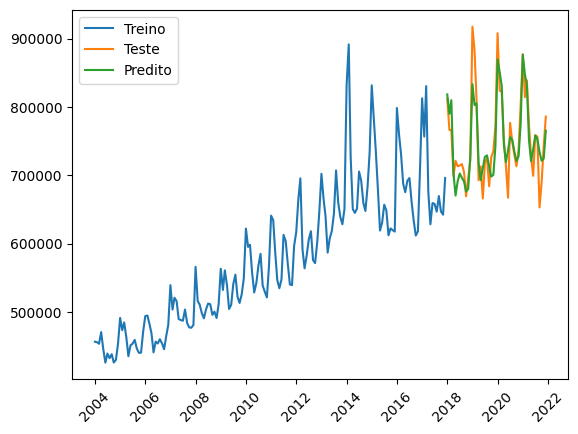

In [57]:
## Plotando os resultados
plt.plot(timestamps_treino,consumo_treino,label='Treino')
plt.plot(timestamps_teste,consumo_teste,label='Teste')
plt.plot(timestamps_teste,consumo_pred,label='Predito')
plt.xticks(rotation=45)
plt.legend()

## Cálculo das Métricas de Avaliação do Modelo
rmse = np.sqrt(mean_squared_error(consumo_teste, consumo_pred))
mae = np.mean(np.abs(consumo_teste - consumo_pred))
r2 = r2_score(consumo_teste, consumo_pred)

# Printando as métricas de avaliação do modelo
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.2f}")